In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


### Top 5 at risk for past 5 years

In [2]:
#Load risk score file
risk = pd.read_csv(r'/Users/saurabhlevin/Deployment/IDS-DRR-Assam-Risk-Model/RiskScoreModel/data/risk_score_final_district.csv')
#Create a dataframe for district level aggregated data (this data is appended at the end of the risk score file, and has no entries for revenue)
risk_dist = risk.loc[risk['revenue-ci'].isnull()]
#calculate average historical risk score for each district and sort in descending order to identify the most at risk districts. topsis-score is used to rank the districts
dist_risk = risk_dist.groupby('district').agg({'topsis-score':'mean'}).reset_index()
dist_risk_sort = dist_risk.sort_values(by='topsis-score', ascending=False)
dist_risk_sort

/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_65991/2795482164.py:2: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  risk = pd.read_csv(r'/Users/saurabhlevin/Deployment/IDS-DRR-Assam-Risk-Model/RiskScoreModel/data/risk_score_final_district.csv')


,district,topsis-score
23,LAKHIMPUR,0.545000
30,SOUTH SALMARA MANCACHAR,0.515679
11,DIBRUGARH,0.506520
3,BISWANATH,0.496228
32,TINSUKIA,0.492159
29,SONITPUR,0.487243
28,SIVASAGAR,0.484477
9,DHEMAJI,0.468547
6,CHARAIDEO,0.460997
2,BARPETA,0.443342


### Script to calculate correlation between flood impact and risk scores, as well as government response

We are considering *flood impact* as a combination of a few priority variables:
inundation, rainfall, damage variables
Government response is a combination of the following variables:
sdrf_sanctions, total_tenders_awarded_value

The following correlations will be calculated (using pearson's coefficient):
- Between flood impact and sdrf sanctions for each financial year from 2021-22 to 2024-25
- Between flood impact and procurement for each financial year from 2021-22 to 2024-25
- Between IDS-DRR risk scores and sdrf sanctions for each financial year from 2021-22 to 2024-25
- Between IDS-DRR risk scores and procurement for each financial year from 2021-22 to 2024-25

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm 
import os
import warnings

In [4]:
risk_dist.columns

Index(['object-id', 'district', 'rc-area', 'timeperiod',
       'total-tender-awarded-value', 'sopd-tenders-awarded-value',
       'sdrf-sanctions-awarded-value', 'sdrf-tenders-awarded-value',
       'ridf-tenders-awarded-value', 'ltif-tenders-awarded-value',
       ...
       'efficiency', 'total-tender-awarded-value-fy-cumsum',
       'sdrf-sanctions-awarded-value-fy-cumsum',
       'sdrf-tenders-awarded-value-fy-cumsum',
       'preparedness-measures-tenders-awarded-value-fy-cumsum',
       'immediate-measures-tenders-awarded-value-fy-cumsum',
       'others-tenders-awarded-value-fy-cumsum', 'topsis-score', 'risk-score',
       'total-infrastructure-damage'],
      dtype='object', length=101)

In [5]:
flood_impact_vars = ['inundation-intensity-sum',  'total-animal-affected',
       'population-affected-total', 'crop-area', 'total-house-fully-damaged', 'human-live-lost',
       'roads', 'bridge','embankment-breached']

flood_impact_df = risk_dist[flood_impact_vars + ['timeperiod', 'object-id']]

flood_impact_df_months = []
for month in tqdm(flood_impact_df.timeperiod.unique()):
    flood_impact_df_month = flood_impact_df[flood_impact_df.timeperiod == month]
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    # Fit scaler to the data and transform it
    flood_impact_df_month[flood_impact_vars] = scaler.fit_transform(flood_impact_df_month[flood_impact_vars])
    
    # Sum scaled flood impact vars
    
    flood_impact_df_month['flood-impact-index'] = flood_impact_df_month[flood_impact_vars].sum(axis=1)

    flood_impact_df_months.append(flood_impact_df_month)

flood_impact = pd.concat(flood_impact_df_months)

flood_risk_df = risk_dist.merge(flood_impact[['timeperiod', 'object-id', 'flood-impact-index']],
                       on = ['timeperiod', 'object-id'])


  0%|          | 0/55 [00:00<?, ?it/s]/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_65991/379553778.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_impact_df_month[flood_impact_vars] = scaler.fit_transform(flood_impact_df_month[flood_impact_vars])
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_65991/379553778.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_impact_df_month['flood-impact-index'] = flood_impact_df_month[flood_impact_vars].sum(axis=1)
/var/folders/

     object-id            district  rc-area timeperiod  \
0       18-799              BAJALI      470    2021_04   
1       18-799              BAJALI      470    2021_05   
2       18-799              BAJALI      470    2021_06   
3       18-799              BAJALI      470    2021_07   
4       18-799              BAJALI      470    2021_08   
...        ...                 ...      ...        ...   
1920    18-759  WEST KARBI ANGLONG     3073    2025_06   
1921    18-759  WEST KARBI ANGLONG     3073    2025_07   
1922    18-759  WEST KARBI ANGLONG     3073    2025_08   
1923    18-759  WEST KARBI ANGLONG     3073    2025_09   
1924    18-759  WEST KARBI ANGLONG     3073    2025_10   

      total-tender-awarded-value  sopd-tenders-awarded-value  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0               

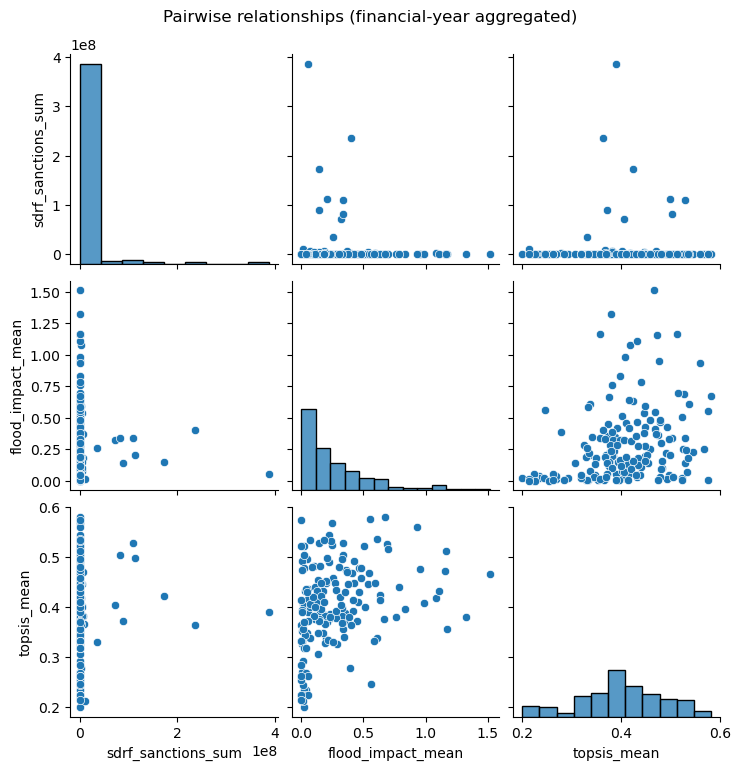

In [6]:
from scipy.stats import pearsonr

# Aggregate SDRF, flood-impact-index and topsis-score by financial year and compute correlations.
# Assumes `risk_dist`, `flood_impact_vars`, `MinMaxScaler`, `pd`, `np`, `sns`, `plt` are available in the notebook.


# Ensure flood-impact-index exists: compute per timeperiod if missing
if 'flood-impact-index' not in globals() and 'flood-impact-index' not in locals():
    if 'flood-impact-index' not in risk_dist.columns:
        # compute scaled flood-impact per timeperiod (does not overwrite global scaler)
        frames = []
        tmp_fi = risk_dist[flood_impact_vars + ['timeperiod', 'object-id']].copy()
        for m in tmp_fi['timeperiod'].unique():
            dfm = tmp_fi[tmp_fi['timeperiod'] == m].copy()
            sc = MinMaxScaler()
            dfm[flood_impact_vars] = sc.fit_transform(dfm[flood_impact_vars])
            dfm['flood-impact-index'] = dfm[flood_impact_vars].sum(axis=1)
            frames.append(dfm[['timeperiod', 'object-id', 'flood-impact-index']])
        flood_index_df = pd.concat(frames, ignore_index=True)
    else:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()
else:
    # if variable exists in workspace as DataFrame/Series, try to use it
    try:
        flood_index_df = flood_risk_df[['timeperiod', 'object-id', 'flood-impact-index']].copy()
    except Exception:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()

# Merge to ensure we have sdrf and topsis and financial-year
df = risk_dist.merge(flood_index_df, on=['timeperiod', 'object-id'], how='left')
print(df)
# Aggregate by financial-year
agg = df.groupby(['financial-year','object-id']).agg(
    sdrf_sanctions_sum=('sdrf-sanctions-awarded-value', 'sum'),
    flood_impact_mean=('flood-impact-index', 'mean'),
    topsis_mean=('topsis-score', 'mean'),
    n_records=('object-id', 'count')
).reset_index()

# Drop years with too few records or all-NaN values for metrics
agg_clean = agg.dropna(subset=['sdrf_sanctions_sum', 'flood_impact_mean', 'topsis_mean'], how='any')

print("Aggregated values by financial year:")
print(agg_clean)

# Compute Pearson correlation matrix (pairwise)
cols = ['sdrf_sanctions_sum', 'flood_impact_mean', 'topsis_mean']
corr_matrix = agg_clean[cols].corr(method='pearson')
print("\nPearson correlation matrix:")
print(corr_matrix)

# Also print pairwise Pearson r and p-values
print("\nPairwise Pearson r and p-values:")
for a in cols:
    for b in cols:
        if a >= b:
            continue
        series_a = agg_clean[a].values
        series_b = agg_clean[b].values
        if len(series_a) < 2:
            print(f"{a} vs {b}: not enough points to compute correlation")
            continue
        r, p = pearsonr(series_a, series_b)
        print(f"{a} vs {b}: r = {r:.3f}, p = {p:.3f}")

# Quick visualization
if len(agg_clean) >= 2:
    sns.pairplot(agg_clean[cols])
    plt.suptitle("Pairwise relationships (financial-year aggregated)", y=1.02)
    plt.show()
else:
    print("\nNot enough aggregated years to plot pairwise relationships.")

## SDRF correlation analysis

In [ ]:
# original script backup
from scipy.stats import pearsonr

monsoon = risk_dist[risk_dist['timeperiod'].str.split('_').str[1].isin(['06', '07', '08', '09'])]
monsoon_risk = monsoon.groupby('district').agg({'topsis-score':'mean'}).reset_index()

# Ensure flood-impact-index exists: compute per timeperiod if missing
if 'flood-impact-index' not in globals() and 'flood-impact-index' not in locals():
    if 'flood-impact-index' not in risk_dist.columns:
        # compute scaled flood-impact per timeperiod
        frames = []
        tmp_fi = risk_dist[flood_impact_vars + ['timeperiod', 'object-id']].copy()
        for m in tmp_fi['timeperiod'].unique():
            dfm = tmp_fi[tmp_fi['timeperiod'] == m].copy()
            sc = MinMaxScaler()
            dfm[flood_impact_vars] = sc.fit_transform(dfm[flood_impact_vars])
            dfm['flood-impact-index'] = dfm[flood_impact_vars].sum(axis=1)
            frames.append(dfm[['timeperiod', 'object-id', 'flood-impact-index']])
        flood_index_df = pd.concat(frames, ignore_index=True)
    else:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()
else:
    try:
        flood_index_df = flood_risk_df[['timeperiod', 'object-id', 'flood-impact-index']].copy()
    except Exception:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()

# Merge to ensure we have sdrf and topsis and financial-year
df = risk_dist.merge(flood_index_df, on=['timeperiod', 'object-id'], how='left')

# Calculate correlations by financial year
financial_years = df['financial-year'].unique()
correlation_data = []
correlation_data_agg = []

for fy in financial_years:
    fy_data = df[df['financial-year'] == fy]
    
    agg = fy_data.groupby(['financial-year','object-id']).agg(
    sdrf_sanctions_sum=('sdrf-sanctions-awarded-value', 'sum'),
    flood_impact_mean=('flood-impact-index', 'mean'),
    topsis_mean=('topsis-score', 'mean'),
    n_records=('object-id', 'count')
    ).reset_index()
    #print(agg)

    # Calculate correlations
    corr_impact_sdrf = pearsonr(fy_data['flood-impact-index'], fy_data['sdrf-sanctions-awarded-value'])[0]
    corr_impact_topsis = pearsonr(fy_data['flood-impact-index'], fy_data['topsis-score'])[0]
    corr_topsis_sdrf = pearsonr(fy_data['topsis-score'], fy_data['sdrf-sanctions-awarded-value'])[0]

    correlation_data.append({
        'financial_year': fy,
        'impact_vs_sdrf': corr_impact_sdrf,
        'impact_vs_topsis': corr_impact_topsis,
        'topsis_vs_sdrf': corr_topsis_sdrf,
        'n_observations': len(fy_data)
    })
    corr_impact_sdrf_agg = pearsonr(agg['flood_impact_mean'], agg['sdrf_sanctions_sum'])[0]
    corr_impact_topsis_agg = pearsonr(agg['flood_impact_mean'], agg['topsis_mean'])[0]
    corr_topsis_sdrf_agg = pearsonr(agg['topsis_mean'], agg['sdrf_sanctions_sum'])[0]
    #print(corr_impact_sdrf_agg, corr_impact_topsis_agg, corr_topsis_sdrf_agg)
    
    correlation_data_agg.append({
        'financial_year': fy,
        'impact_vs_sdrf': corr_impact_sdrf_agg,
        'impact_vs_topsis': corr_impact_topsis_agg,
        'topsis_vs_sdrf': corr_topsis_sdrf_agg,
        'n_observations': len(agg)
    })
    print(correlation_data_agg)
# Create correlation dataframe
correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.sort_values('financial_year')

# Display results
print("Correlation coefficients by financial year:")
print(correlation_df.round(3))

# Create visualization
plt.figure(figsize=(10, 6))
for col in ['impact_vs_sdrf', 'impact_vs_topsis', 'topsis_vs_sdrf']:
    plt.plot(correlation_df['financial_year'], correlation_df[col], marker='o', label=col)

plt.title('Correlation Coefficients by Financial Year')
plt.xlabel('Financial Year')
plt.ylabel('Correlation Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


correlation_df_agg = pd.DataFrame(correlation_data_agg)
correlation_df_agg = correlation_df_agg.sort_values('financial_year')
# Create visualization
plt.figure(figsize=(10, 6))
for col in ['impact_vs_sdrf', 'impact_vs_topsis', 'topsis_vs_sdrf']:
    plt.plot(correlation_df_agg['financial_year'], correlation_df_agg[col], marker='o', label=col)

plt.title('Correlation Coefficients by Financial Year')
plt.xlabel('Financial Year')
plt.ylabel('Correlation Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


  financial_year  impact_vs_sdrf  impact_vs_topsis_monsoon  \
0      2021-2022           0.082                     0.352   
1      2022-2023           0.028                    -0.036   
2      2023-2024           0.201                     0.415   
3      2024-2025          -0.044                     0.428   
4      2025-2026          -0.133                     0.588   

   topsis_monsoon_vs_sdrf  n_observations  
0                   0.150              35  
1                   0.236              35  
2                  -0.115              35  
3                  -0.060              35  
4                  -0.145              35  


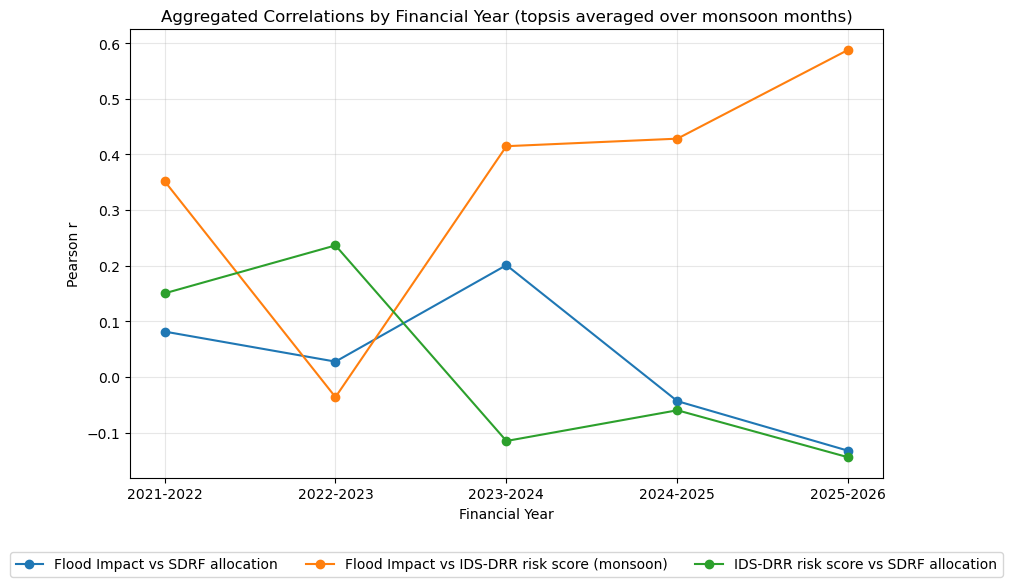

In [13]:
from scipy.stats import pearsonr

# prepare flood-impact-index (reuse existing logic)
if 'flood-impact-index' not in globals() and 'flood-impact-index' not in locals():
    if 'flood-impact-index' not in risk_dist.columns:
        frames = []
        tmp_fi = risk_dist[flood_impact_vars + ['timeperiod', 'object-id']].copy()
        for m in tmp_fi['timeperiod'].unique():
            dfm = tmp_fi[tmp_fi['timeperiod'] == m].copy()
            sc = MinMaxScaler()
            dfm[flood_impact_vars] = sc.fit_transform(dfm[flood_impact_vars])
            dfm['flood-impact-index'] = dfm[flood_impact_vars].sum(axis=1)
            frames.append(dfm[['timeperiod', 'object-id', 'flood-impact-index']])
        flood_index_df = pd.concat(frames, ignore_index=True)
    else:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()
else:
    try:
        flood_index_df = flood_risk_df[['timeperiod', 'object-id', 'flood-impact-index']].copy()
    except Exception:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()

# merge to get a working dataframe
df = risk_dist.merge(flood_index_df, on=['timeperiod', 'object-id'], how='left')

# extract month and prepare monsoon topsis mean (only Jun-Sep)
df['month'] = df['timeperiod'].str.split('_').str[1]
monsoon_months = ['06', '07', '08', '09']
monsoon = df[df['month'].isin(monsoon_months)].copy()
topsis_monsoon = monsoon.groupby(['financial-year', 'object-id'])['topsis-score'] \
                       .mean().reset_index().rename(columns={'topsis-score': 'topsis_monsoon_mean'})

# aggregate other indicators by financial-year & object-id (as before)
agg = df.groupby(['financial-year', 'object-id']).agg(
    sdrf_sanctions_sum=('sdrf-sanctions-awarded-value', 'sum'),
    flood_impact_mean=('flood-impact-index', 'mean'),
    tenders_sum=('total-tender-awarded-value', 'sum'),
    n_records=('object-id', 'count')
).reset_index()

# merge monsoon-only topsis into the aggregated frame
agg = agg.merge(topsis_monsoon, on=['financial-year', 'object-id'], how='left')

# compute correlations per financial year using the aggregated indicators,
# with topsis coming from monsoon months only (topsis_monsoon_mean)
financial_years = agg['financial-year'].unique()
correlation_data_agg = []

for fy in financial_years:
    sub = agg[agg['financial-year'] == fy].dropna(subset=['flood_impact_mean', 'sdrf_sanctions_sum', 'topsis_monsoon_mean'])
    if len(sub) < 2:
        correlation_data_agg.append({
            'financial_year': fy,
            'impact_vs_sdrf': None,
            'impact_vs_topsis_monsoon': None,
            'topsis_monsoon_vs_sdrf': None,
            'n_observations': len(sub)
        })
        continue

    try:
        r1, p1 = pearsonr(sub['flood_impact_mean'], sub['sdrf_sanctions_sum'])
    except Exception:
        r1 = None
    try:
        r2, p2 = pearsonr(sub['flood_impact_mean'], sub['topsis_monsoon_mean'])
    except Exception:
        r2 = None
    try:
        r3, p3 = pearsonr(sub['topsis_monsoon_mean'], sub['sdrf_sanctions_sum'])
    except Exception:
        r3 = None

    correlation_data_agg.append({
        'financial_year': fy,
        'impact_vs_sdrf': r1,
        'impact_vs_topsis_monsoon': r2,
        'topsis_monsoon_vs_sdrf': r3,
        'n_observations': len(sub)
    })

correlation_df_agg = pd.DataFrame(correlation_data_agg).sort_values('financial_year')
print(correlation_df_agg.round(3))

# plot
plt.figure(figsize=(10, 6))
for col in ['impact_vs_sdrf', 'impact_vs_topsis_monsoon', 'topsis_monsoon_vs_sdrf']:
    label_map = {
        'impact_vs_sdrf': 'Flood Impact vs SDRF allocation',
        'impact_vs_topsis_monsoon': 'Flood Impact vs IDS-DRR risk score (monsoon)',
        'topsis_monsoon_vs_sdrf': 'IDS-DRR risk score vs SDRF allocation'
    }
    plt.plot(
        correlation_df_agg['financial_year'],
        correlation_df_agg[col],
        marker='o',
        label=label_map.get(col, col)
    )
plt.title('Aggregated Correlations by Financial Year (topsis averaged over monsoon months)')
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.xlabel('Financial Year')
plt.ylabel('Pearson r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


  financial_year  impact_vs_sdrf_dcor  impact_vs_topsis_monsoon_dcor  \
0      2021-2022                0.257                          0.476   
1      2022-2023                0.194                          0.353   
2      2023-2024                0.347                          0.474   
3      2024-2025                0.213                          0.589   
4      2025-2026                0.156                          0.605   

   topsis_monsoon_vs_sdrf_dcor  n_observations  
0                        0.343              35  
1                        0.340              35  
2                        0.215              35  
3                        0.216              35  
4                        0.194              35  


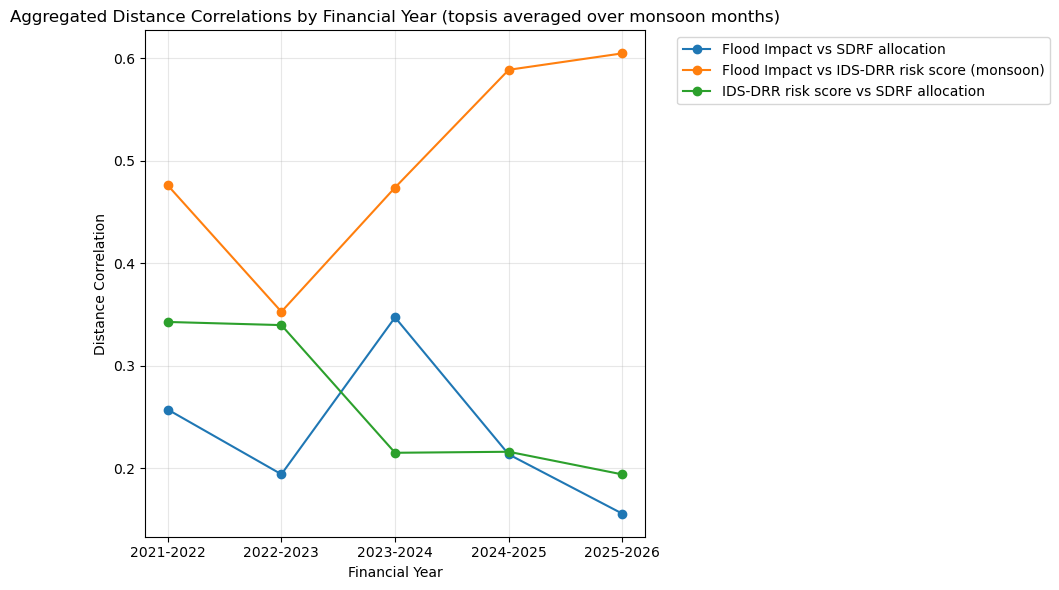

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import dcor  # install via `pip install dcor`

# prepare flood-impact-index (reuse existing logic)
if 'flood-impact-index' not in globals() and 'flood-impact-index' not in locals():
    if 'flood-impact-index' not in risk_dist.columns:
        frames = []
        tmp_fi = risk_dist[flood_impact_vars + ['timeperiod', 'object-id']].copy()
        for m in tmp_fi['timeperiod'].unique():
            dfm = tmp_fi[tmp_fi['timeperiod'] == m].copy()
            sc = MinMaxScaler()
            dfm[flood_impact_vars] = sc.fit_transform(dfm[flood_impact_vars])
            dfm['flood-impact-index'] = dfm[flood_impact_vars].sum(axis=1)
            frames.append(dfm[['timeperiod', 'object-id', 'flood-impact-index']])
        flood_index_df = pd.concat(frames, ignore_index=True)
    else:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()
else:
    try:
        flood_index_df = flood_risk_df[['timeperiod', 'object-id', 'flood-impact-index']].copy()
    except Exception:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()

# merge to get a working dataframe
df = risk_dist.merge(flood_index_df, on=['timeperiod', 'object-id'], how='left')

# extract month and prepare monsoon topsis mean (only Jun-Sep)
df['month'] = df['timeperiod'].str.split('_').str[1]
monsoon_months = ['06', '07', '08', '09']
monsoon = df[df['month'].isin(monsoon_months)].copy()
topsis_monsoon = monsoon.groupby(['financial-year', 'object-id'])['topsis-score'] \
                       .mean().reset_index().rename(columns={'topsis-score': 'topsis_monsoon_mean'})

# aggregate other indicators by financial-year & object-id
agg = df.groupby(['financial-year', 'object-id']).agg(
    sdrf_sanctions_sum=('sdrf-sanctions-awarded-value', 'sum'),
    flood_impact_mean=('flood-impact-index', 'mean'),
    tenders_sum=('total-tender-awarded-value', 'sum'),
    n_records=('object-id', 'count')
).reset_index()

# merge monsoon-only topsis into the aggregated frame
agg = agg.merge(topsis_monsoon, on=['financial-year', 'object-id'], how='left')

# compute correlations per financial year using Distance Correlation
financial_years = agg['financial-year'].unique()
correlation_data_agg = []

for fy in financial_years:
    sub = agg[agg['financial-year'] == fy].dropna(subset=['flood_impact_mean', 'sdrf_sanctions_sum', 'topsis_monsoon_mean'])
    if len(sub) < 2:
        correlation_data_agg.append({
            'financial_year': fy,
            'impact_vs_sdrf_dcor': None,
            'impact_vs_topsis_monsoon_dcor': None,
            'topsis_monsoon_vs_sdrf_dcor': None,
            'n_observations': len(sub)
        })
        continue

    try:
        r1 = dcor.distance_correlation(sub['flood_impact_mean'], sub['sdrf_sanctions_sum'])
    except Exception:
        r1 = None
    try:
        r2 = dcor.distance_correlation(sub['flood_impact_mean'], sub['topsis_monsoon_mean'])
    except Exception:
        r2 = None
    try:
        r3 = dcor.distance_correlation(sub['topsis_monsoon_mean'], sub['sdrf_sanctions_sum'])
    except Exception:
        r3 = None

    correlation_data_agg.append({
        'financial_year': fy,
        'impact_vs_sdrf_dcor': r1,
        'impact_vs_topsis_monsoon_dcor': r2,
        'topsis_monsoon_vs_sdrf_dcor': r3,
        'n_observations': len(sub)
    })

correlation_df_agg = pd.DataFrame(correlation_data_agg).sort_values('financial_year')
print(correlation_df_agg.round(3))

# plot
plt.figure(figsize=(10, 6))
for col in ['impact_vs_sdrf_dcor', 'impact_vs_topsis_monsoon_dcor', 'topsis_monsoon_vs_sdrf_dcor']:
    label_map = {
        'impact_vs_sdrf_dcor': 'Flood Impact vs SDRF allocation',
        'impact_vs_topsis_monsoon_dcor': 'Flood Impact vs IDS-DRR risk score (monsoon)',
        'topsis_monsoon_vs_sdrf_dcor': 'IDS-DRR risk score vs SDRF allocation'
    }
    plt.plot(
        correlation_df_agg['financial_year'],
        correlation_df_agg[col],
        marker='o',
        label=label_map.get(col, col)
    )
    plt.title('Aggregated Distance Correlations by Financial Year (topsis averaged over monsoon months)')
plt.xlabel('Financial Year')
plt.ylabel('Distance Correlation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


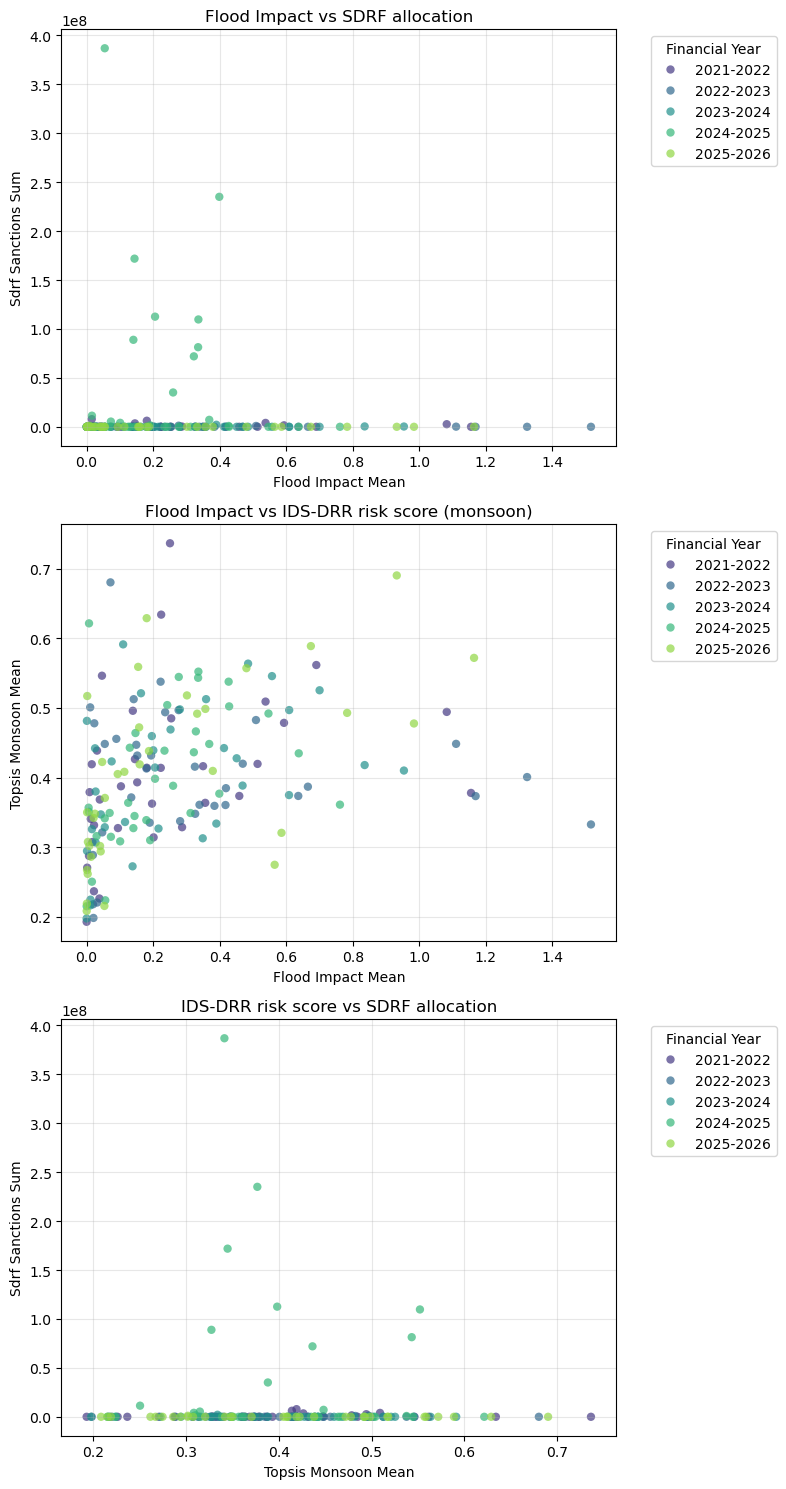

In [14]:
# --- Scatterplots for visual inspection of relationships ---
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize=(8, 15))
pairs = [
    ('flood_impact_mean', 'sdrf_sanctions_sum', 'Flood Impact vs SDRF allocation'),
    ('flood_impact_mean', 'topsis_monsoon_mean', 'Flood Impact vs IDS-DRR risk score (monsoon)'),
    ('topsis_monsoon_mean', 'sdrf_sanctions_sum', 'IDS-DRR risk score vs SDRF allocation')
]

for ax, (x, y, title) in zip(axes, pairs):
    sns.scatterplot(
        data=agg,
        x=x,
        y=y,
        hue='financial-year',
        palette='viridis',
        ax=ax,
        alpha=0.7,
        edgecolor='none'
    )
    ax.set_title(title)
    ax.set_xlabel(x.replace('_', ' ').title())
    ax.set_ylabel(y.replace('_', ' ').title())
    ax.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Procurement Correlation analysis

/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/3185400107.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_impact_tender = pearsonr(fy_data['flood-impact-index'], fy_data['total-tender-awarded-value'])[0]
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/3185400107.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_topsis_tender = pearsonr(fy_data['topsis-score'], fy_data['total-tender-awarded-value'])[0]
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/3185400107.py:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_impact_tender_agg = pearsonr(agg['flood_impact_mean'], agg['tenders_sum'])[0]
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/3185400107.py:55: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  c

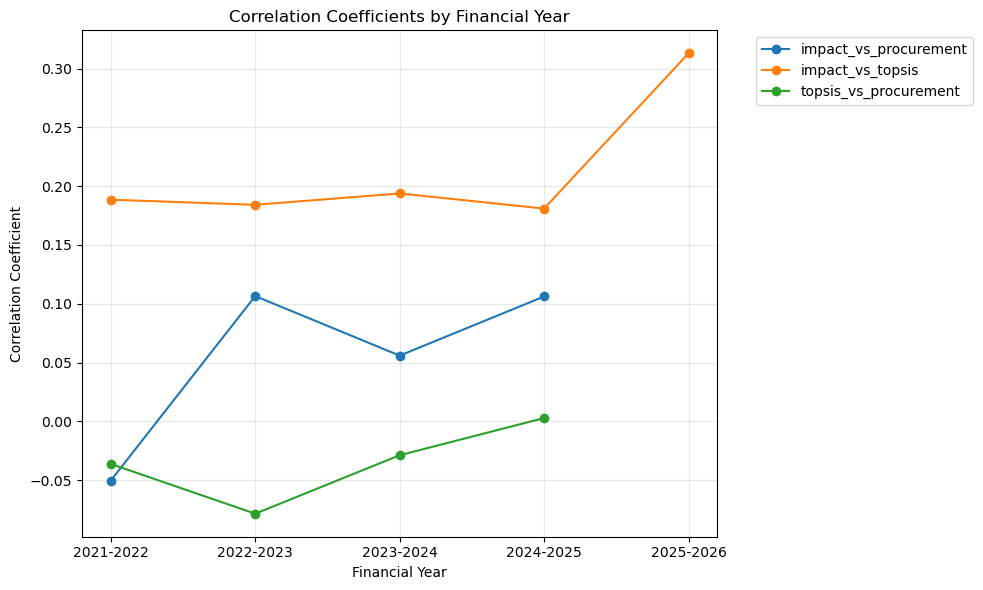

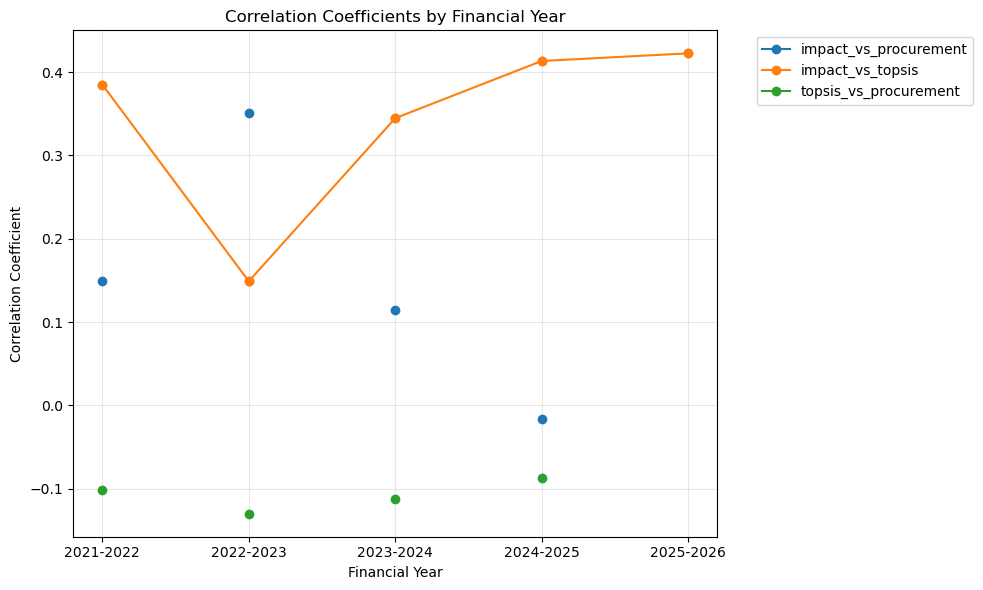

In [43]:
from scipy.stats import pearsonr

# Ensure flood-impact-index exists: compute per timeperiod if missing
if 'flood-impact-index' not in globals() and 'flood-impact-index' not in locals():
    if 'flood-impact-index' not in risk_dist.columns:
        # compute scaled flood-impact per timeperiod
        frames = []
        tmp_fi = risk_dist[flood_impact_vars + ['timeperiod', 'object-id']].copy()
        for m in tmp_fi['timeperiod'].unique():
            dfm = tmp_fi[tmp_fi['timeperiod'] == m].copy()
            sc = MinMaxScaler()
            dfm[flood_impact_vars] = sc.fit_transform(dfm[flood_impact_vars])
            dfm['flood-impact-index'] = dfm[flood_impact_vars].sum(axis=1)
            frames.append(dfm[['timeperiod', 'object-id', 'flood-impact-index']])
        flood_index_df = pd.concat(frames, ignore_index=True)
    else:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()
else:
    try:
        flood_index_df = flood_risk_df[['timeperiod', 'object-id', 'flood-impact-index']].copy()
    except Exception:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()

# Merge to ensure we have sdrf and topsis and financial-year
df = risk_dist.merge(flood_index_df, on=['timeperiod', 'object-id'], how='left')

# Calculate correlations by financial year
financial_years = df['financial-year'].unique()
correlation_data = []

for fy in financial_years:
    fy_data = df[df['financial-year'] == fy]

    agg = fy_data.groupby(['financial-year','object-id']).agg(
    tenders_sum=('total-tender-awarded-value', 'sum'),
    flood_impact_mean=('flood-impact-index', 'mean'),
    topsis_mean=('topsis-score', 'mean'),
    n_records=('object-id', 'count')
    ).reset_index()
    
    # Calculate correlations
    corr_impact_tender = pearsonr(fy_data['flood-impact-index'], fy_data['total-tender-awarded-value'])[0]
    corr_impact_topsis = pearsonr(fy_data['flood-impact-index'], fy_data['topsis-score'])[0]
    corr_topsis_tender = pearsonr(fy_data['topsis-score'], fy_data['total-tender-awarded-value'])[0]
    
    correlation_data.append({
        'financial_year': fy,
        'impact_vs_procurement': corr_impact_tender,
        'impact_vs_topsis': corr_impact_topsis,
        'topsis_vs_procurement': corr_topsis_tender,
        'n_observations': len(fy_data)
    })
    corr_impact_tender_agg = pearsonr(agg['flood_impact_mean'], agg['tenders_sum'])[0]
    corr_impact_topsis_agg = pearsonr(agg['flood_impact_mean'], agg['topsis_mean'])[0]
    corr_topsis_tender_agg = pearsonr(agg['topsis_mean'], agg['tenders_sum'])[0]
    #print(corr_impact_sdrf_agg, corr_impact_topsis_agg, corr_topsis_sdrf_agg)
    
    correlation_data_agg.append({
        'financial_year': fy,
        'impact_vs_procurement': corr_impact_tender_agg,
        'impact_vs_topsis': corr_impact_topsis_agg,
        'topsis_vs_procurement': corr_topsis_tender_agg,
        'n_observations': len(agg)
    })
    #print(correlation_data_agg)

# Create correlation dataframe
correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.sort_values('financial_year')

# Display results
#print("Correlation coefficients by financial year:")
#print(correlation_df.round(3))

# Create visualization
plt.figure(figsize=(10, 6))
for col in ['impact_vs_procurement', 'impact_vs_topsis', 'topsis_vs_procurement']:
    plt.plot(correlation_df['financial_year'], correlation_df[col], marker='o', label=col)

plt.title('Correlation Coefficients by Financial Year')
plt.xlabel('Financial Year')
plt.ylabel('Correlation Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


correlation_df_agg = pd.DataFrame(correlation_data_agg)
correlation_df_agg = correlation_df_agg.sort_values('financial_year')

# Create visualization
plt.figure(figsize=(10, 6))
for col in ['impact_vs_procurement', 'impact_vs_topsis', 'topsis_vs_procurement']:
    plt.plot(correlation_df_agg['financial_year'], correlation_df_agg[col], marker='o', label=col)

plt.title('Correlation Coefficients by Financial Year')
plt.xlabel('Financial Year')
plt.ylabel('Correlation Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Correlation between SDRF allocation and all other indicators

In [50]:
corr_col = [
 'total-animal-washed-away',
 'total-animal-affected',
 'population-affected-total',
 'crop-area',
 'total-house-fully-damaged',
 'human-live-lost',
 'embankments-affected',
 'roads',
 'bridge',
 'embankment-breached',
 'sum-rain',
 'inundation-intensity-sum',
 
 'relief-camps',
 'relief-centers',
 'relief-inmates',
 
 'mean-sex-ratio',
 'sum-population',
 'net-sown-area-in-hac',
 'avg-electricity',
 'avg-tele',
 'rc-piped-hhds-pct',
 'rc-nosanitation-hhds-pct',
 'total-hhd',
 'distance-from-river',

 'total-infrastructure-damage',
 'flood-impact-index']

/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/2834631992.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(s[target_col].values, s[col].values)
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/2834631992.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(s[target_col].values, s[col].values)
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/2834631992.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(s[target_col].values, s[col].values)
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/2834631992.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(s[target_col].values, s[col].values)
/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_31357/2834631

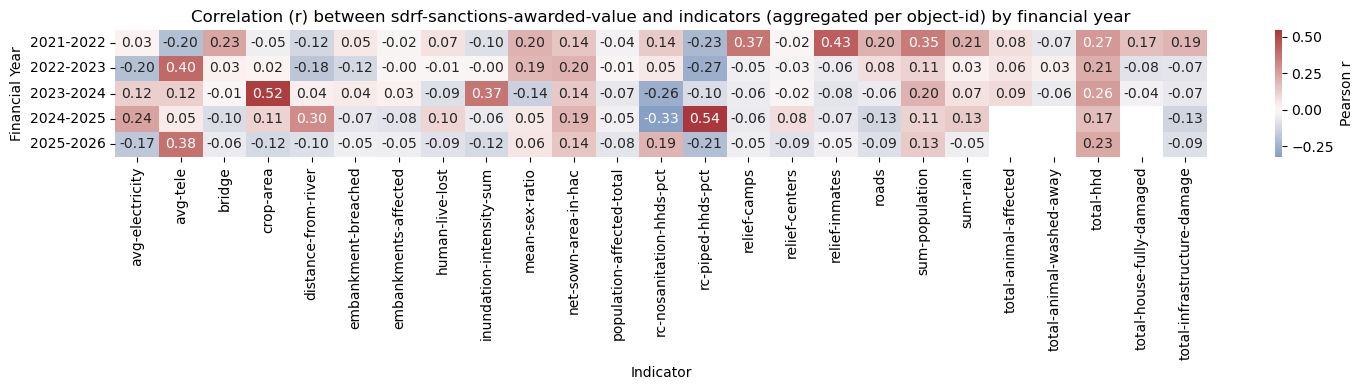

Correlation results (per financial year):
    financial_year                    indicator         r         p   n
0        2021-2022              avg-electricity  0.025443  0.884647  35
1        2021-2022                     avg-tele -0.204507  0.238619  35
2        2021-2022                       bridge  0.229478  0.184813  35
3        2021-2022                    crop-area -0.049318  0.778446  35
4        2021-2022          distance-from-river -0.122143  0.484560  35
..             ...                          ...       ...       ...  ..
120      2025-2026        total-animal-affected       NaN       NaN  35
121      2025-2026     total-animal-washed-away       NaN       NaN  35
122      2025-2026                    total-hhd  0.226994  0.189744  35
123      2025-2026    total-house-fully-damaged       NaN       NaN  35
124      2025-2026  total-infrastructure-damage -0.094139  0.590643  35

[125 rows x 5 columns]


In [51]:
# Pairwise correlation of indicators in `corr_col` vs SDRF sanctions, aggregated by financial year.
# Assumes: `risk_dist`, `corr_col`, `pd`, `np`, `sns`, `plt`, `pearsonr` are available in the notebook.

target_col = 'sdrf-sanctions-awarded-value'

# keep only indicators that exist in the dataframe
indicators = [c for c in corr_col if c in risk_dist.columns]
if target_col not in risk_dist.columns:
    raise KeyError(f"Target column '{target_col}' not found in risk_dist")

if not indicators:
    raise ValueError("No indicators from corr_col found in risk_dist columns")

# simple heuristic to choose aggregation: sum for "total/amount/value/..." else mean
sum_keywords = ['value', 'amount', 'total', 'sum', 'fund', 'tender', 'expenditure',
                'damage', 'lost', 'affected', 'area', 'count', 'length', 'house', 'crop',
                'inundation', 'roads', 'bridge', 'embankment']
def choose_agg(col):
    lower = col.lower()
    return 'sum' if any(k in lower for k in sum_keywords) else 'mean'

# build aggregation dict for groupby (financial-year, object-id)
agg_dict = {target_col: 'sum'}
for col in indicators:
    agg_dict[col] = choose_agg(col)

# aggregate by financial-year & object-id (so correlations are across object-ids within each FY)
agg = risk_dist.groupby(['financial-year', 'object-id']).agg(agg_dict).reset_index()

# compute Pearson r for each FY and each indicator
rows = []
for fy in sorted(agg['financial-year'].unique()):
    sub = agg[agg['financial-year'] == fy].dropna(subset=[target_col])
    # require at least 2 non-null rows to compute correlation
    for col in indicators:
        s = sub[[target_col, col]].dropna()
        if s.shape[0] < 2:
            rows.append({'financial_year': fy, 'indicator': col, 'r': np.nan, 'p': np.nan, 'n': s.shape[0]})
            continue
        try:
            r, p = pearsonr(s[target_col].values, s[col].values)
        except Exception:
            r, p = np.nan, np.nan
        rows.append({'financial_year': fy, 'indicator': col, 'r': r, 'p': p, 'n': s.shape[0]})

corr_results = pd.DataFrame(rows)

# pivot to have financial-year x indicators for heatmap (use r)
heatmap_df = corr_results.pivot(index='financial_year', columns='indicator', values='r')

# plot heatmap of Pearson r (rows: financial-year, cols: indicators)
plt.figure(figsize=(max(10, 0.6 * len(heatmap_df.columns)), max(4, 0.6 * len(heatmap_df.index))))
sns.heatmap(heatmap_df, center=0, cmap='vlag', annot=True, fmt='.2f', cbar_kws={'label': 'Pearson r'})
plt.title(f"Correlation (r) between {target_col} and indicators (aggregated per object-id) by financial year")
plt.xlabel("Indicator")
plt.ylabel("Financial Year")
plt.tight_layout()
plt.show()

# print results table sorted
display_cols = ['financial_year', 'indicator', 'r', 'p', 'n']
print("Correlation results (per financial year):")
print(corr_results[display_cols].sort_values(['financial_year','indicator']).reset_index(drop=True))

In [ ]:
from scipy.stats import pearsonr

# Ensure flood-impact-index exists: compute per timeperiod if missing
if 'flood-impact-index' not in globals() and 'flood-impact-index' not in locals():
    if 'flood-impact-index' not in risk_dist.columns:
        # compute scaled flood-impact per timeperiod
        frames = []
        tmp_fi = risk_dist[flood_impact_vars + ['timeperiod', 'object-id']].copy()
        for m in tmp_fi['timeperiod'].unique():
            dfm = tmp_fi[tmp_fi['timeperiod'] == m].copy()
            sc = MinMaxScaler()
            dfm[flood_impact_vars] = sc.fit_transform(dfm[flood_impact_vars])
            dfm['flood-impact-index'] = dfm[flood_impact_vars].sum(axis=1)
            frames.append(dfm[['timeperiod', 'object-id', 'flood-impact-index']])
        flood_index_df = pd.concat(frames, ignore_index=True)
    else:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()
else:
    try:
        flood_index_df = flood_risk_df[['timeperiod', 'object-id', 'flood-impact-index']].copy()
    except Exception:
        flood_index_df = risk_dist[['timeperiod', 'object-id', 'flood-impact-index']].copy()

# Merge to ensure we have sdrf and topsis and financial-year
df = risk_dist.merge(flood_index_df, on=['timeperiod', 'object-id'], how='left')

# Calculate correlations by financial year
financial_years = df['financial-year'].unique()
correlation_data = []
correlation_data_agg = []

for fy in financial_years:
    fy_data = df[df['financial-year'] == fy]
    
    agg = fy_data.groupby(['financial-year','object-id']).agg(
    sdrf_sanctions_sum=('sdrf-sanctions-awarded-value', 'sum'),
    flood_impact_mean=('flood-impact-index', 'mean'),
    topsis_mean=('topsis-score', 'mean'),
    n_records=('object-id', 'count')
    ).reset_index()
    #print(agg)

    # Calculate correlations
    corr_impact_sdrf = pearsonr(fy_data['flood-impact-index'], fy_data['sdrf-sanctions-awarded-value'])[0]
    corr_impact_topsis = pearsonr(fy_data['flood-impact-index'], fy_data['topsis-score'])[0]
    corr_topsis_sdrf = pearsonr(fy_data['topsis-score'], fy_data['sdrf-sanctions-awarded-value'])[0]

    correlation_data.append({
        'financial_year': fy,
        'impact_vs_sdrf': corr_impact_sdrf,
        'impact_vs_topsis': corr_impact_topsis,
        'topsis_vs_sdrf': corr_topsis_sdrf,
        'n_observations': len(fy_data)
    })
    corr_impact_sdrf_agg = pearsonr(agg['flood_impact_mean'], agg['sdrf_sanctions_sum'])[0]
    corr_impact_topsis_agg = pearsonr(agg['flood_impact_mean'], agg['topsis_mean'])[0]
    corr_topsis_sdrf_agg = pearsonr(agg['topsis_mean'], agg['sdrf_sanctions_sum'])[0]
    #print(corr_impact_sdrf_agg, corr_impact_topsis_agg, corr_topsis_sdrf_agg)
    
    correlation_data_agg.append({
        'financial_year': fy,
        'impact_vs_sdrf': corr_impact_sdrf_agg,
        'impact_vs_topsis': corr_impact_topsis_agg,
        'topsis_vs_sdrf': corr_topsis_sdrf_agg,
        'n_observations': len(agg)
    })
    print(correlation_data_agg)
# Create correlation dataframe
correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.sort_values('financial_year')

# Display results
print("Correlation coefficients by financial year:")
print(correlation_df.round(3))

# Create visualization
plt.figure(figsize=(10, 6))
for col in ['impact_vs_sdrf', 'impact_vs_topsis', 'topsis_vs_sdrf']:
    plt.plot(correlation_df['financial_year'], correlation_df[col], marker='o', label=col)

plt.title('Correlation Coefficients by Financial Year')
plt.xlabel('Financial Year')
plt.ylabel('Correlation Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


correlation_df_agg = pd.DataFrame(correlation_data_agg)
correlation_df_agg = correlation_df_agg.sort_values('financial_year')
# Create visualization
plt.figure(figsize=(10, 6))
for col in ['impact_vs_sdrf', 'impact_vs_topsis', 'topsis_vs_sdrf']:
    plt.plot(correlation_df_agg['financial_year'], correlation_df_agg[col], marker='o', label=col)

plt.title('Correlation Coefficients by Financial Year')
plt.xlabel('Financial Year')
plt.ylabel('Correlation Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


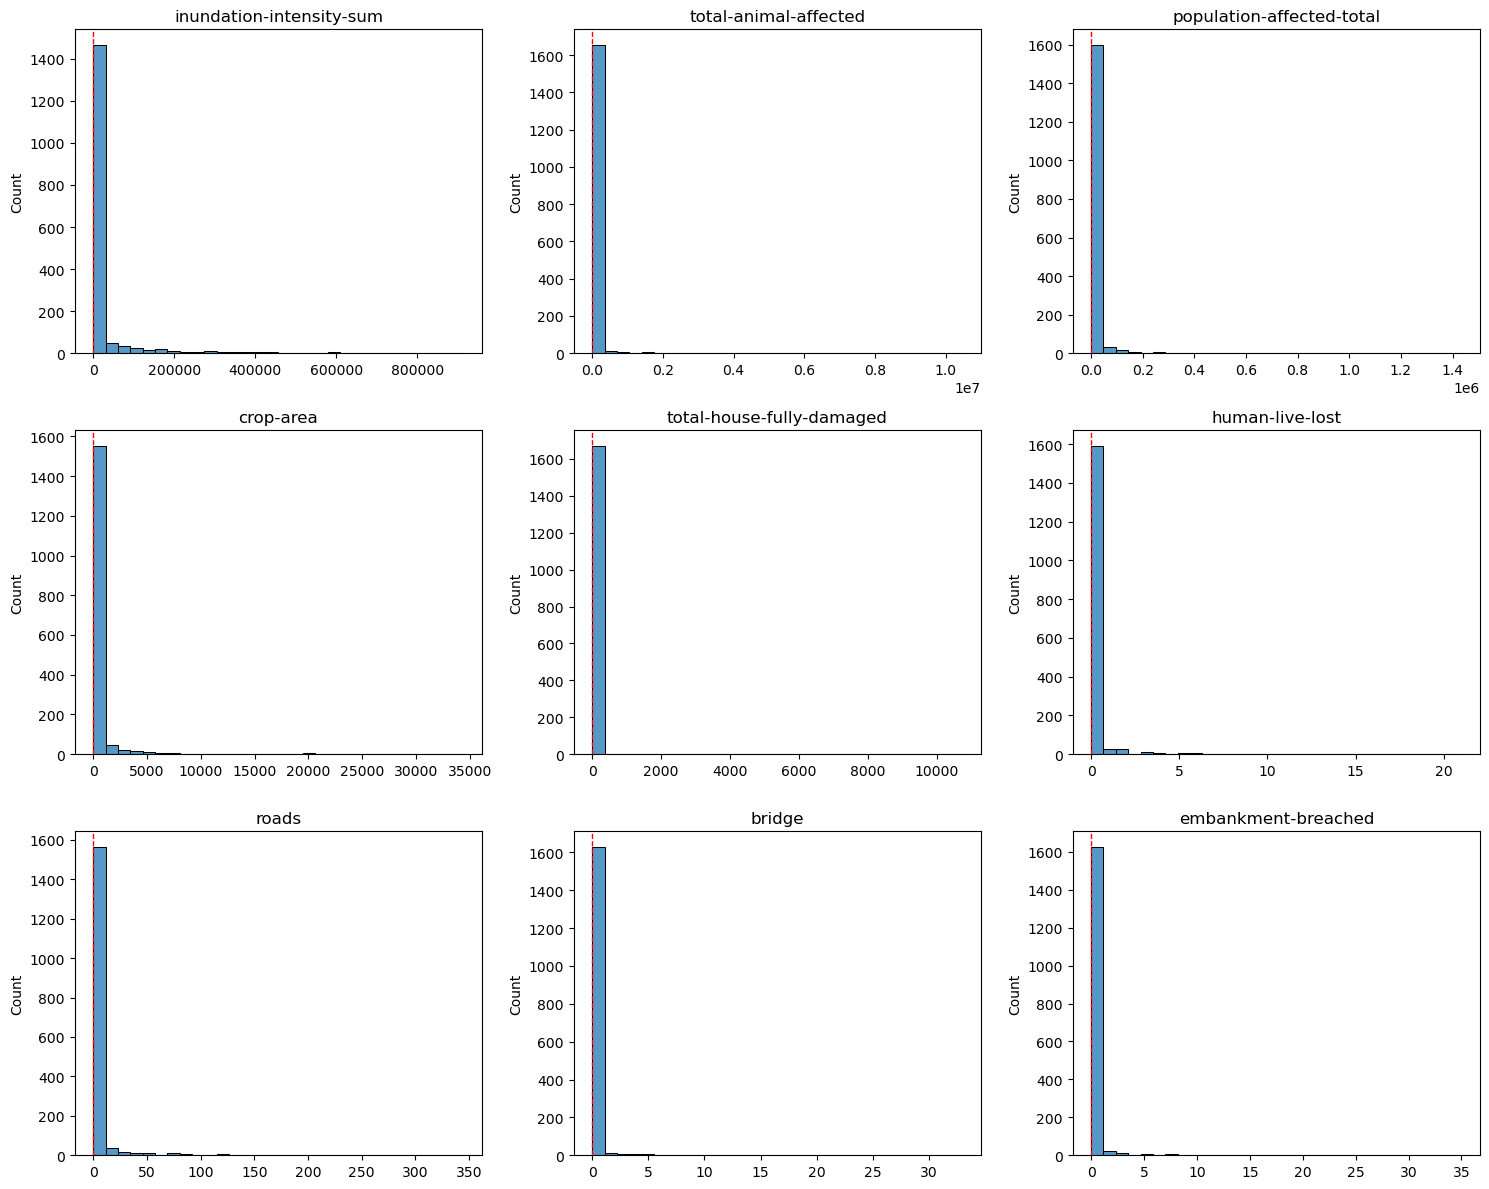

In [10]:
# Plot histograms for all flood impact variables
# Assumes `risk_dist`, `flood_impact_vars`, matplotlib.pyplot as plt and seaborn as sns are already available in the notebook.

vars_to_plot = [v for v in flood_impact_vars if v in risk_dist.columns]
if not vars_to_plot:
    raise ValueError("No flood impact variables found in risk_dist. Check the variable names.")

n = len(vars_to_plot)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for ax, var in zip(axes, vars_to_plot):
    data = risk_dist[var].dropna()
    sns.histplot(data, bins=30, kde=False, ax=ax, color='C0')
    ax.set_title(var)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    # show median line for reference
    if not data.empty:
        ax.axvline(data.median(), color='red', linestyle='--', linewidth=1)

# turn off any unused subplots
for ax in axes[len(vars_to_plot):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Top 10 districts with highest risk scores 2023-24
risk_dist_23_24 = risk_dist.loc[risk_dist['financial-year'] == "2023'2024"]
dist_risk_23_24 = risk_dist_23_24.groupby('district').agg({'topsis-score':'mean'}).reset_index()
dist_risk_sort = dist_risk.sort_values(by='topsis-score', ascending=False)
dist_risk_sort['district'].str.title().head(10).to_list()

['Lakhimpur',
 'Dibrugarh',
 'South Salmara Mancachar',
 'Tinsukia',
 'Biswanath',
 'Sonitpur',
 'Sivasagar',
 'Dhemaji',
 'Charaideo',
 'Barpeta']

In [4]:
# Calculate the average factor scores for the top five districts
for n in dist_risk_sort['district'].head(10):
    a = risk_dist.loc[risk_dist['district']==n].agg({'exposure':'mean'})
    b = risk_dist.loc[risk_dist['district']==n].agg({'flood-hazard':'mean'})
    c = risk_dist.loc[risk_dist['district']==n].agg({'vulnerability':'mean'})
    d = risk_dist.loc[risk_dist['district']==n].agg({'government-response':'mean'})
    e = risk_dist.loc[risk_dist['district']==n].agg({'risk-score':'mean'})
    print(n , '=' , a,b,c,d,e)    

LAKHIMPUR = exposure    1.0
dtype: float64 flood-hazard    3.166667
dtype: float64 vulnerability    4.166667
dtype: float64 government-response    4.916667
dtype: float64 risk-score    3.4375
dtype: float64
DIBRUGARH = exposure    2.0
dtype: float64 flood-hazard    2.9375
dtype: float64 vulnerability    3.958333
dtype: float64 government-response    4.708333
dtype: float64 risk-score    3.1875
dtype: float64
SOUTH SALMARA MANCACHAR = exposure    4.5625
dtype: float64 flood-hazard    2.895833
dtype: float64 vulnerability    2.041667
dtype: float64 government-response    5.0
dtype: float64 risk-score    3.0625
dtype: float64
TINSUKIA = exposure    5.0
dtype: float64 flood-hazard    2.645833
dtype: float64 vulnerability    4.020833
dtype: float64 government-response    4.916667
dtype: float64 risk-score    3.1875
dtype: float64
BISWANATH = exposure    2.0
dtype: float64 flood-hazard    2.833333
dtype: float64 vulnerability    4.145833
dtype: float64 government-response    4.5625
dtype: fl

In [5]:
# Calculate the average factor scores for the top five districts
for n in dist_risk_sort['district'].head(5):
    a = risk_dist.loc[risk_dist['district']==n].agg({'exposure':'mean'})
    b = risk_dist.loc[risk_dist['district']==n].agg({'flood-hazard':'mean'})
    c = risk_dist.loc[risk_dist['district']==n].agg({'vulnerability':'mean'})
    d = risk_dist.loc[risk_dist['district']==n].agg({'government-response':'mean'})
    print(n , '=' , a,b,c,d)    

LAKHIMPUR = exposure    1.0
dtype: float64 flood-hazard    3.166667
dtype: float64 vulnerability    4.166667
dtype: float64 government-response    4.916667
dtype: float64
DIBRUGARH = exposure    2.0
dtype: float64 flood-hazard    2.9375
dtype: float64 vulnerability    3.958333
dtype: float64 government-response    4.708333
dtype: float64
SOUTH SALMARA MANCACHAR = exposure    4.5625
dtype: float64 flood-hazard    2.895833
dtype: float64 vulnerability    2.041667
dtype: float64 government-response    5.0
dtype: float64
TINSUKIA = exposure    5.0
dtype: float64 flood-hazard    2.645833
dtype: float64 vulnerability    4.020833
dtype: float64 government-response    4.916667
dtype: float64
BISWANATH = exposure    2.0
dtype: float64 flood-hazard    2.833333
dtype: float64 vulnerability    4.145833
dtype: float64 government-response    4.5625
dtype: float64


### Specific indicators

In [5]:
#Use this code block to rank districts by specific indicators. replace ".agg({'indicator':'aggregation method'}" with the appropriate indicator and aggregation methods can be sum, min,max, mean - choose appropriately for the indicator.
lives_lost = risk_dist.groupby('district').agg({'human-live-lost':'sum'}).reset_index()
#sort by descending. replace indicator in "sort_values(by='indicator', ascending=False) with the indicator you want to rank by
lives_lost = lives_lost.sort_values(by='human-live-lost', ascending=False)
lives_lost

,district,human-live-lost
5,CACHAR,69
26,NAGAON,34
2,BARPETA,30
25,MORIGAON,17
14,GOLAGHAT,13
9,DHEMAJI,12
21,KARIMGANJ,12
13,GOALPARA,12
27,NALBARI,10
8,DARRANG,8


In [6]:
crop_loss = risk_dist.groupby('district').agg({'crop-area':'sum'}).reset_index()
crop_loss = crop_loss.sort_values(by='crop-area', ascending=False)
crop_loss

,district,crop-area
26,NAGAON,92262.0
25,MORIGAON,77080.0
2,BARPETA,73079.0
8,DARRANG,65913.0
9,DHEMAJI,60483.0
24,MAJULI,39577.0
18,KAMRUP,33435.0
23,LAKHIMPUR,32776.0
13,GOALPARA,31999.0
5,CACHAR,30667.0


In [7]:
sanctions = risk_dist.groupby('district').agg({'sdrf-sanctions-awarded-value':'sum'}).reset_index()
sanctions = sanctions.sort_values(by='sdrf-sanctions-awarded-value', ascending=True)
sanctions

,district,sdrf-sanctions-awarded-value
17,JORHAT,0.000000e+00
14,GOLAGHAT,0.000000e+00
21,KARIMGANJ,0.000000e+00
12,DIMA HASAO,0.000000e+00
11,DIBRUGARH,0.000000e+00
24,MAJULI,0.000000e+00
25,MORIGAON,0.000000e+00
15,HAILAKANDI,0.000000e+00
28,SIVASAGAR,0.000000e+00
6,CHARAIDEO,0.000000e+00


In [8]:
embankments = risk_dist.groupby('district').agg({'embankment-breached':'sum'}).reset_index()
embankments = embankments.sort_values(by='embankment-breached', ascending=False)
embankments

,district,embankment-breached
5,CACHAR,85.0
8,DARRANG,40.0
3,BISWANATH,28.0
33,UDALGURI,25.0
27,NALBARI,22.0
31,TAMULPUR,21.0
17,JORHAT,14.0
0,BAJALI,12.0
4,BONGAIGAON,12.0
2,BARPETA,9.0


In [6]:
# procurement
#expenditure
dist_tender = risk_dist.groupby('district').agg({'total-tender-awarded-value':'sum'})
#dist_response = risk_dist.groupby('district').agg({'government-response':'mean'}).reset_index()
dist_tender_sort = dist_tender.sort_values(by='total-tender-awarded-value', ascending=False)
dist_tender_sort


,total-tender-awarded-value
district,
KAMRUP METRO,5.213861e+09
MORIGAON,3.943250e+09
DIBRUGARH,3.027094e+09
NAGAON,2.475595e+09
DHEMAJI,1.941042e+09
DARRANG,1.618640e+09
MAJULI,1.605325e+09
CHIRANG,1.464378e+09
KARIMGANJ,1.409815e+09


In [8]:
dist_tender_sort['total-tender-awarded-value'].sum()

np.float64(39751154240.7)

In [5]:
#expenditure
dist_sdrf = risk_dist.groupby('district').agg({'total-expenditure-value':'sum'})
#dist_response = risk_dist.groupby('district').agg({'government-response':'mean'}).reset_index()
dist_sdrf_sort = dist_sdrf.sort_values(by='total-expenditure-value', ascending=False)
dist_sdrf_sort

,total-expenditure-value
district,
KOKRAJHAR,542781900.0
DIBRUGARH,514021000.0
BARPETA,452217530.0
KAMRUP METRO,361540000.0
DHUBRI,335242358.0
DHEMAJI,311851207.0
TINSUKIA,304304000.0
NAGAON,299277000.0
GOLAGHAT,272500000.0


In [ ]:
dist_sdrf_sort['to']

In [ ]:
# Highest and lowest funding received
risk_dist['total-funds'] = risk_dist['sdrf-sanctions-awarded-value'] + risk_dist['total-tender-awarded-value']
dist_response = risk_dist.groupby('district').agg({'total-funds':'sum'})
#dist_response = risk_dist.groupby('district').agg({'government-response':'mean'}).reset_index()
dist_response_sort = dist_response.sort_values(by='total-funds')#, ascending=False)
dist_response_sort

C:\Users\saura\AppData\Local\Temp\ipykernel_39052\234644770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_dist['total-funds'] = risk_dist['sdrf-sanctions-awarded-value'] + risk_dist['total-tender-awarded-value']


,total-funds
district,
SIVASAGAR,0.000000e+00
KARBI ANGLONG,9.000000e+04
DIMA HASAO,6.270000e+06
BONGAIGAON,3.464561e+07
HOJAI,8.885033e+07
CHARAIDEO,1.046393e+08
BAJALI,1.522176e+08
WEST KARBI ANGLONG,1.552478e+08
SOUTH SALMARA MANCACHAR,1.978338e+08


### Vulnerability score
This section is used to calculate the average vulnerability scores. This is used to identify districts with high losses and damages

In [13]:
# Load the vulnerability score file and calculate the average vulnerability score for each district. This is done for the monsoon months only, and the districts are sorted in descending order to identify the most vulnerable districts.
vul = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\factor_scores_l1_vulnerability.csv')
vul_monsoon = vul.loc[vul['timeperiod'].str.split('_').str[1].isin(['06', '07', '08', '09'])]
#vul_ranking = vul_monsoon.groupby('district').agg({'landd_score':'sum'}).reset_index()
vul_ranking = vul.groupby('district').agg({'landd_score':'sum'}).reset_index()

vul_ranking = vul_ranking.sort_values(by='landd_score', ascending=False)
for m in vul_ranking['district']:#.head(10):
    a = vul.loc[vul['district']==m].agg({'landd_score':'sum'})
    b = risk_dist.loc[risk_dist['district']==m].agg({'flood-hazard':'mean'})
    c = risk_dist.loc[risk_dist['district']==m].agg({'vulnerability':'mean'})
    d = risk_dist.loc[risk_dist['district']==m].agg({'government-response':'mean'})
    print(m , '=' , a,b,c,d)

KAMRUP = landd_score    593.932677
dtype: float64 flood-hazard    1.844444
dtype: float64 vulnerability    1.977778
dtype: float64 government-response    4.377778
dtype: float64
UDALGURI = landd_score    406.874358
dtype: float64 flood-hazard    1.933333
dtype: float64 vulnerability    3.955556
dtype: float64 government-response    5.0
dtype: float64
NALBARI = landd_score    373.631786
dtype: float64 flood-hazard    2.2
dtype: float64 vulnerability    1.088889
dtype: float64 government-response    5.0
dtype: float64
KOKRAJHAR = landd_score    363.305807
dtype: float64 flood-hazard    2.022222
dtype: float64 vulnerability    2.955556
dtype: float64 government-response    4.866667
dtype: float64
NAGAON = landd_score    323.561983
dtype: float64 flood-hazard    1.711111
dtype: float64 vulnerability    2.777778
dtype: float64 government-response    4.711111
dtype: float64
DHUBRI = landd_score    318.619309
dtype: float64 flood-hazard    2.755556
dtype: float64 vulnerability    2.133333
dty

<Axes: >

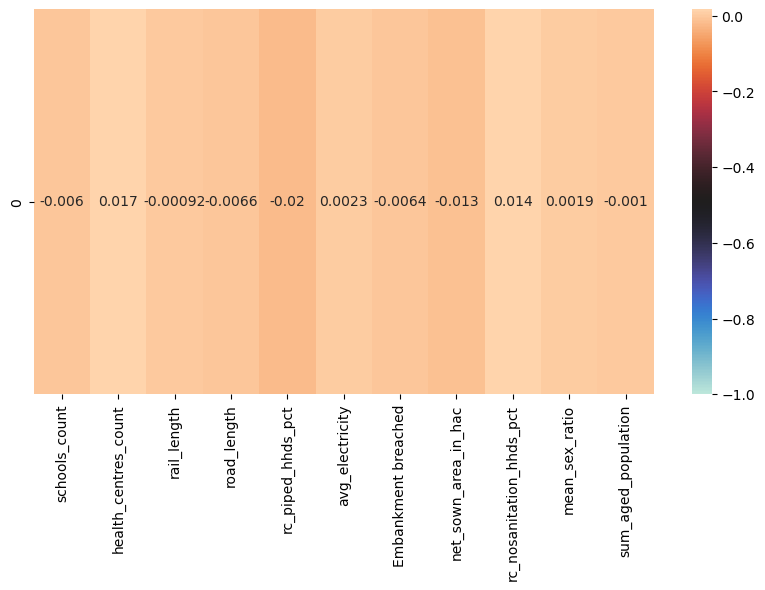

In [20]:
# correlation between landd score and sdrf sanctions
plt.figure(figsize=(10,5))
corr_series = vul[["schools_count", "health_centres_count", "rail_length", "road_length",
				   "rc_piped_hhds_pct", "avg_electricity", "Embankment breached",
				   "net_sown_area_in_hac", "rc_nosanitation_hhds_pct", "mean_sex_ratio",
				   "sum_aged_population"]].corrwith(vul['SDRF_sanctions_awarded_value'])
# Convert the Series to a DataFrame and transpose so we get a 2D structure
corr_df = corr_series.to_frame().T
sns.heatmap(corr_df, vmin=-1, annot=True, cmap="icefire")

In [83]:
vulnerability_vars = ["mean_sex_ratio",
                      "schools_count",
                      "health_centres_count",
                      "rail_length",
                      "road_length",
                      "net_sown_area_in_hac",
                      "avg_electricity",
                      "rc_piped_hhds_pct",
                      
                      "rc_nosanitation_hhds_pct",
                      "sum_aged_population",
                      "Embankment breached",
                     ]
damage_vars = [#"Total_Animal_Affected","Total_House_Fully_Damaged"
               "Human_Live_Lost","Population_affected_Total", "Crop_Area","Embankments affected",
                 "Roads","Bridge"]

infratructure_vars = ["Embankment breached","Roads", "Bridge"]
infratructure_vars_form = ["embankment-breached","roads", "bridge"]
vul['infrastructure_damage'] = vul[infratructure_vars].sum(axis=1)
risk_dist['infrastructure-damage'] = risk_dist[infratructure_vars_form].sum(axis=1)


all_vars = {"mean_sex_ratio":"mean",
            "schools_count":"max",
            "health_centres_count":"max",
            "rail_length":"max",
            "road_length":"max",
            "net_sown_area_in_hac":"max",
            "avg_electricity":"max",
            "rc_piped_hhds_pct":"max",
            
            "rc_nosanitation_hhds_pct":"max",
            "sum_aged_population":"max",
            "Embankment breached":"sum",
            "Human_Live_Lost":"sum",
            "Population_affected_Total":"max", 
            "Crop_Area":"sum",
            "Embankments affected":"max",
            "Roads":"sum",
            "Bridge":"sum",
            "infrastructure_damage":"sum"
            }

all_vars_risk_formatted = {
    "mean-sex-ratio": "mean",
    "schools-count": "max",
    "health-centres-count": "max",
    "rail-length": "max",
    "road-length": "max",
    "net-sown-area-in-hac": "max",
    "avg-electricity": "max",
    "rc-piped-hhds-pct": "max",
    "rc-nosanitation-hhds-pct": "max",
    "sum-aged-population": "max",
    "embankment-breached": "sum",
    "human-live-lost": "sum",
    "population-affected-total": "max",
    "crop-area": "sum",
    "embankments-affected": "max",
    "roads": "sum",
    "bridge": "sum",
    "infrastructure-damage": "sum",
}


C:\Users\saura\AppData\Local\Temp\ipykernel_46384\1164114225.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_dist['infrastructure-damage'] = risk_dist[infratructure_vars_form].sum(axis=1)


In [80]:
infrastructure_rank = risk_dist.groupby('district').agg({'infrastructure-damage':'sum'}).reset_index()
infrastructure_rank = infrastructure_rank.sort_values(by='infrastructure-damage', ascending=False)
infrastructure_rank

,district,infrastructure-damage
2,BARPETA,1049.0
5,CACHAR,784.0
27,NALBARI,597.0
26,NAGAON,567.0
10,DHUBRI,480.0
8,DARRANG,424.0
0,BAJALI,403.0
4,BONGAIGAON,384.0
18,KAMRUP,367.0
21,KARIMGANJ,360.0


In [84]:
for n in dist_risk_sort['district'][14:16]:
    for m in all_vars.keys():
        avg = vul.loc[vul['district'] == n, m].agg(all_vars[m])
        print(f"{n} - {m} = {avg}")

CACHAR - mean_sex_ratio = 0.9399176093088927
CACHAR - schools_count = 1064
CACHAR - health_centres_count = 71
CACHAR - rail_length = 42280.08533136024
CACHAR - road_length = 394328.9813114788
CACHAR - net_sown_area_in_hac = 20596.63
CACHAR - avg_electricity = 11.475855130784709
CACHAR - rc_piped_hhds_pct = 17.466564090424903
CACHAR - rc_nosanitation_hhds_pct = 24.905314238371403
CACHAR - sum_aged_population = 46411.68200000003
CACHAR - Embankment breached = 85.0
CACHAR - Human_Live_Lost = 69
CACHAR - Population_affected_Total = 725306.0
CACHAR - Crop_Area = 30667.26
CACHAR - Embankments affected = 13.0
CACHAR - Roads = 698.0
CACHAR - Bridge = 1.0
CACHAR - infrastructure_damage = 784.0
MAJULI - mean_sex_ratio = 0.9416277114980678
MAJULI - schools_count = 423
MAJULI - health_centres_count = 20
MAJULI - rail_length = 0.0
MAJULI - road_length = 33932.77730119641
MAJULI - net_sown_area_in_hac = 10909.71
MAJULI - avg_electricity = 9.435180143388692
MAJULI - rc_piped_hhds_pct = 7.813776204737

In [ ]:
# SDRF SANCTIONs for top5 at risk
for n in dist_risk_sort['district'][14:16]:
    for f in risk_dist['financial-year'].unique():
        avg = risk_dist.loc[(risk_dist['district'] == n) & (risk_dist['financial-year'] == f), 'sdrf-sanctions-awarded-value'].agg(sum)
        print(f"{n} - {f} - {'sdrf-sanction'} = {avg}")

CACHAR - 2021-2022 - sdrf-sanction = 0.0
CACHAR - 2022-2023 - sdrf-sanction = 0.0
CACHAR - 2023-2024 - sdrf-sanction = 0.0
CACHAR - 2024-2025 - sdrf-sanction = 0.0
MAJULI - 2021-2022 - sdrf-sanction = 0.0
MAJULI - 2022-2023 - sdrf-sanction = 0.0
MAJULI - 2023-2024 - sdrf-sanction = 0.0
MAJULI - 2024-2025 - sdrf-sanction = 0.0


C:\Users\saura\AppData\Local\Temp\ipykernel_46384\2393937449.py:3: FutureWarning: The provided callable <built-in function sum> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  avg = risk_dist.loc[(risk_dist['district'] == n) & (risk_dist['financial-year'] == f), 'sdrf-sanctions-awarded-value'].agg(sum)


In [85]:
# Calculate the average factor scores for the selected districts and variables
for n in dist_risk_sort['district'][14:16]:
    for f in risk_dist['financial-year'].unique():
        for m in all_vars_risk_formatted.keys():
            avg = risk_dist.loc[(risk_dist['district'] == n) & (risk_dist['financial-year'] == f), m].agg(all_vars_risk_formatted[m])
            print(f"{n} - {f} - {m} = {avg}")
            #for m in all_vars.keys():
            #    avg = vul.loc[vul['district'] == n, m].agg(all_vars[m])
            #    print(f"{n} - {m} = {avg}")
    

CACHAR - 2021-2022 - mean-sex-ratio = 0.9399999999999998
CACHAR - 2021-2022 - schools-count = 3322
CACHAR - 2021-2022 - health-centres-count = 176
CACHAR - 2021-2022 - rail-length = 103488.0
CACHAR - 2021-2022 - road-length = 988230.0
CACHAR - 2021-2022 - net-sown-area-in-hac = 66721.37
CACHAR - 2021-2022 - avg-electricity = 9.8
CACHAR - 2021-2022 - rc-piped-hhds-pct = 8.53
CACHAR - 2021-2022 - rc-nosanitation-hhds-pct = 15.87
CACHAR - 2021-2022 - sum-aged-population = 107625.0
CACHAR - 2021-2022 - embankment-breached = 0.0
CACHAR - 2021-2022 - human-live-lost = 0
CACHAR - 2021-2022 - population-affected-total = 0.0
CACHAR - 2021-2022 - crop-area = 874.0
CACHAR - 2021-2022 - embankments-affected = 0.0
CACHAR - 2021-2022 - roads = 0.0
CACHAR - 2021-2022 - bridge = 0.0
CACHAR - 2021-2022 - infrastructure-damage = 0.0
CACHAR - 2022-2023 - mean-sex-ratio = 0.9399999999999998
CACHAR - 2022-2023 - schools-count = 3322
CACHAR - 2022-2023 - health-centres-count = 176
CACHAR - 2022-2023 - rail-

In [74]:
for n in lives_lost['district'].head(5):
    for m in all_vars_risk_formatted.keys():
        avg = risk_dist.loc[(risk_dist['district'] == n) , m].agg(all_vars_risk_formatted[m])
        print(f"{n} -  {m} = {avg}")

CACHAR -  mean-sex-ratio = 0.9399999999999996
CACHAR -  schools-count = 3322
CACHAR -  health-centres-count = 176
CACHAR -  rail-length = 103488.0
CACHAR -  road-length = 988230.0
CACHAR -  net-sown-area-in-hac = 66721.37000000001
CACHAR -  avg-electricity = 9.8
CACHAR -  rc-piped-hhds-pct = 8.53
CACHAR -  rc-nosanitation-hhds-pct = 15.87
CACHAR -  sum-aged-population = 115757.0
CACHAR -  embankment-breached = 85.0
CACHAR -  human-live-lost = 69
CACHAR -  population-affected-total = 1434750.0
CACHAR -  crop-area = 10630.0
CACHAR -  embankments-affected = 17.0
CACHAR -  roads = 698.0
CACHAR -  bridge = 1.0
CACHAR -  infrastructure-damage = 784.0
NAGAON -  mean-sex-ratio = 0.9399999999999996
NAGAON -  schools-count = 3284
NAGAON -  health-centres-count = 277
NAGAON -  rail-length = 174517.0
NAGAON -  road-length = 1331470.0
NAGAON -  net-sown-area-in-hac = 87424.202
NAGAON -  avg-electricity = 9.8
NAGAON -  rc-piped-hhds-pct = 4.98
NAGAON -  rc-nosanitation-hhds-pct = 23.51
NAGAON -  sum

### Top 5 at risk vulnerability indicators

In [58]:
# Calculate the average factor scores for the selected districts and variables
for n in dist_risk_sort['district'].head(5):
    for f in risk_dist['financial-year'].unique():
        for m in all_vars_risk_formatted.keys():
            avg = risk_dist.loc[(risk_dist['district'] == n) & (risk_dist['financial-year'] == f), m].agg(all_vars_risk_formatted[m])
            print(f"{n} - {f} - {m} = {avg}")
            #for m in all_vars.keys():
            #    avg = vul.loc[vul['district'] == n, m].agg(all_vars[m])
            #    print(f"{n} - {m} = {avg}")
    

LAKHIMPUR - 2021-2022 - mean-sex-ratio = 0.9399999999999998
LAKHIMPUR - 2021-2022 - schools-count = 3519
LAKHIMPUR - 2021-2022 - health-centres-count = 124
LAKHIMPUR - 2021-2022 - rail-length = 108334.0
LAKHIMPUR - 2021-2022 - road-length = 804067.0
LAKHIMPUR - 2021-2022 - net-sown-area-in-hac = 90513.46103
LAKHIMPUR - 2021-2022 - avg-electricity = 8.3
LAKHIMPUR - 2021-2022 - rc-piped-hhds-pct = 2.83
LAKHIMPUR - 2021-2022 - rc-nosanitation-hhds-pct = 16.32
LAKHIMPUR - 2021-2022 - sum-aged-population = 58342.0
LAKHIMPUR - 2021-2022 - embankment-breached = 0.0
LAKHIMPUR - 2021-2022 - human-live-lost = 0
LAKHIMPUR - 2021-2022 - population-affected-total = 128234.0
LAKHIMPUR - 2021-2022 - crop-area = 8551.0
LAKHIMPUR - 2021-2022 - embankments-affected = 1.0
LAKHIMPUR - 2021-2022 - roads = 3.0
LAKHIMPUR - 2021-2022 - bridge = 0.0
LAKHIMPUR - 2021-2022 - infrastructure-damage = 3.0
LAKHIMPUR - 2022-2023 - mean-sex-ratio = 0.9399999999999998
LAKHIMPUR - 2022-2023 - schools-count = 3519
LAKHIM

In [ ]:
# Identify the districts with the districts highest
risk_dist['total-funds'] = risk_dist['sdrf-sanctions-awarded-value'] + risk_dist['total-tender-awarded-value']#
#dist_response = risk_dist.groupby('district').agg({'total-funds':'sum'})
dist_response = risk_dist.groupby('district').agg({'government-response':'mean'}).reset_index()
dist_response_sort = dist_response.sort_values(by='government-response', ascending=False)
dist_response_sort

C:\Users\saura\AppData\Local\Temp\ipykernel_49156\3513192972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_dist['total-funds'] = risk_dist['total-expenditure-value'] + risk_dist['total-tender-awarded-value']#


,district,government-response
0,BAJALI,5.000000
12,DIMA HASAO,5.000000
33,UDALGURI,5.000000
30,SOUTH SALMARA MANCACHAR,5.000000
28,SIVASAGAR,5.000000
27,NALBARI,5.000000
20,KARBI ANGLONG,5.000000
1,BAKSA,5.000000
15,HAILAKANDI,5.000000
14,GOLAGHAT,5.000000


In [ ]:
risk_dist = risk_dist.loc[risk_dist['financial-year'] == '2023-2024']

In [50]:
# Identify the districts with the districts highest
risk = pd.read_csv(r'/Users/saurabhlevin/Deployment/IDS-DRR-Assam-Risk-Model/RiskScoreModel/data/risk_score_final_district.csv')
risk_dist = risk.loc[risk['revenue-ci'].isnull()]
risk_dist['total-funds'] = risk_dist['sdrf-sanctions-awarded-value'] 
#risk_dist['total-funds'] = risk_dist['total-tender-awarded-value']+ risk_dist['sdrf-sanctions-awarded-value'] 
for fy in risk_dist['financial-year'].unique():
    print(fy)
    dist_risk = risk_dist.copy().loc[risk_dist['financial-year'] == fy]
    dist_response = risk_dist.groupby('financial-year').agg({'total-funds':'sum'})
    #dist_response = risk_dist.groupby('district').agg({'government-response':'mean'}).reset_index()
    #dist_response_sort = dist_response.sort_values(by='total-funds', ascending=False)
    dist_response['total'] = dist_response['total-funds']*0.012

    print(dist_response)#.head(5))


2021-2022
                 total-funds          total
financial-year                             
2021-2022       2.607532e+07  312903.810924
2022-2023       2.693148e+06   32317.780672
2023-2024       3.944435e+06   47333.215686
2024-2025       0.000000e+00       0.000000
2022-2023
                 total-funds          total
financial-year                             
2021-2022       2.607532e+07  312903.810924
2022-2023       2.693148e+06   32317.780672
2023-2024       3.944435e+06   47333.215686
2024-2025       0.000000e+00       0.000000
2023-2024
                 total-funds          total
financial-year                             
2021-2022       2.607532e+07  312903.810924
2022-2023       2.693148e+06   32317.780672
2023-2024       3.944435e+06   47333.215686
2024-2025       0.000000e+00       0.000000
2024-2025
                 total-funds          total
financial-year                             
2021-2022       2.607532e+07  312903.810924
2022-2023       2.693148e+06   32317

/var/folders/mn/tyjcr2q91wz11fzw0ttcj3780000gn/T/ipykernel_43210/2095062758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_dist['total-funds'] = risk_dist['sdrf-sanctions-awarded-value']


In [ ]:
risk_dist = risk_dist.loc[risk_dist['financial-year'] == '2022-2023']
dist_response = risk_dist.groupby('district').agg({'total-funds':'sum'})
#dist_response = risk_dist.groupby('district').agg({'government-response':'mean'}).reset_index()
dist_response_sort = dist_response.sort_values(by='total-funds', ascending=False)
dist_response_sort

In [42]:
total = dist_response_sort['total-funds'].sum()
total = total*0.012
total

np.float64(151065440.77451226)

## Monsoon calculations

In [18]:
# Calculate the average risk score only for the monsoon months. Follows a similar process as above, but only for the months of June, July, August and September.  
monsoon = risk_dist[risk_dist['timeperiod'].str.split('_').str[1].isin(['06', '07', '08', '09'])]
monsoon_risk = monsoon.groupby('district').agg({'topsis-score':'mean'}).reset_index()
monsoon_risk_sort = monsoon_risk.sort_values(by='topsis-score', ascending=False)
monsoon_risk_csv = []
for m in monsoon_risk_sort['district'].head(5):
    a = monsoon.loc[monsoon['district']==m].agg({'exposure':'mean'})
    b = monsoon.loc[monsoon['district']==m].agg({'flood-hazard':'mean'})
    c = monsoon.loc[monsoon['district']==m].agg({'vulnerability':'mean'})
    d = monsoon.loc[monsoon['district']==m].agg({'government-response':'mean'})
    e = monsoon.loc[monsoon['district']==m].agg({'topsis-score':'mean'})

    #e = monsoon.loc[monsoon['district']==m].agg({'landd-score':'mean'})
    #print(m , '=' , a,b,c,d)#,e)
    monsoon_risk_csv.append([m, a.values[0], b.values[0], c.values[0], d.values[0]])#, e.values[0]])
monsoon_risk_csv = pd.DataFrame(monsoon_risk_csv, columns=['district', 'exposure', 'flood-hazard', 'vulnerability', 'government-response'])
monsoon_risk_csv#.to_csv(r'D:\CivicDataLab_IDS-DRR\ASDMA Meetings\Pre-monsoon-2025_SDRF\monsoon_risk_district.csv', index=False)


,district,exposure,flood-hazard,vulnerability,government-response
0,SOUTH SALMARA MANCACHAR,4.5,3.5000,2.1250,5.0000
1,LAKHIMPUR,1.0,2.9375,4.3750,5.0000
2,SONITPUR,5.0,2.8750,3.8750,4.6250
3,BARPETA,3.0,3.0000,2.8750,4.4375
4,SIVASAGAR,2.0,3.1875,2.9375,5.0000


### Top 5 at risk 2024-2025

In [2]:
risk = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\risk_score_final_district.csv')
risk_dist = risk.loc[risk['revenue-ci'].isnull()]
fy_2024 = ['2024_04','2024_05','2024_06','2024_07','2024_08','2024_09','2024_10','2024_11','2024_12','2025_01','2025_02','2025_03']
risk_2024_25 = risk_dist.loc[risk_dist['timeperiod'].isin(fy_2024)]
risk_2022_23 = risk_dist.loc[risk_dist['financial-year']=='2023-2024']
risk_2022_23

C:\Users\saura\AppData\Local\Temp\ipykernel_49156\3212882080.py:1: DtypeWarning: Columns (69,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  risk = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\risk_score_final_district.csv')


,object-id,district,rc-area,timeperiod,total-tender-awarded-value,sopd-tenders-awarded-value,sdrf-sanctions-awarded-value,sdrf-tenders-awarded-value,ridf-tenders-awarded-value,ltif-tenders-awarded-value,...,drainage-density,exposure,flood-hazard,flood-hazard-float,government-response,financial-year,vulnerability,efficiency,topsis-score,risk-score
8124,18-799,BAJALI,470,2023_04,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000681,1,4,NaN,5,2023-2024,1,0.977035,0.559291,4
8125,18-799,BAJALI,470,2023_05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000681,1,2,NaN,5,2023-2024,1,0.977035,0.308184,1
8126,18-799,BAJALI,470,2023_06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000681,1,5,NaN,5,2023-2024,1,0.973026,0.633947,4
8127,18-799,BAJALI,470,2023_07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000681,1,2,NaN,5,2023-2024,1,0.959467,0.348908,2
8128,18-799,BAJALI,470,2023_08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000681,1,3,NaN,5,2023-2024,1,0.981003,0.469876,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9661,18-759,WEST KARBI ANGLONG,3073,2023_11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000439,3,3,NaN,5,2023-2024,4,0.805140,0.533788,4
9662,18-759,WEST KARBI ANGLONG,3073,2023_12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000439,3,3,NaN,5,2023-2024,4,0.805140,0.533788,3
9663,18-759,WEST KARBI ANGLONG,3073,2024_01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000439,3,1,NaN,5,2023-2024,4,0.805980,0.292692,2
9664,18-759,WEST KARBI ANGLONG,3073,2024_02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000439,3,1,NaN,5,2023-2024,4,0.805980,0.292692,2


In [6]:
dist_risk_2223 = risk_2022_23.groupby('district').agg({'topsis-score':'mean'}).reset_index()
dist_sort_2223 = dist_risk_2223.sort_values(by='topsis-score', ascending=False)
dist_sort_2223

,district,topsis-score
23,LAKHIMPUR,0.576622
3,BISWANATH,0.537589
11,DIBRUGARH,0.525574
30,SOUTH SALMARA MANCACHAR,0.523714
28,SIVASAGAR,0.516169
32,TINSUKIA,0.505235
6,CHARAIDEO,0.479166
2,BARPETA,0.479046
9,DHEMAJI,0.475093
24,MAJULI,0.474510


In [19]:
dist_risk_2425 = risk_2024_25.groupby('district').agg({'topsis-score':'mean'}).reset_index()
dist_sort = dist_risk_2425.sort_values(by='topsis-score', ascending=False)
dist_sort

,district,topsis-score
21,KARIMGANJ,0.536036
30,SOUTH SALMARA MANCACHAR,0.531752
11,DIBRUGARH,0.487695
2,BARPETA,0.478961
23,LAKHIMPUR,0.473408
15,HAILAKANDI,0.472468
10,DHUBRI,0.468628
28,SIVASAGAR,0.462065
5,CACHAR,0.461285
6,CHARAIDEO,0.458497


In [35]:
top10_list = dist_sort['district'].head(10).tolist()
print("Top 10 districts in dist_sort:", top10_list)

Top 10 districts in dist_sort: ['KARIMGANJ', 'SOUTH SALMARA MANCACHAR', 'DIBRUGARH', 'BARPETA', 'LAKHIMPUR', 'HAILAKANDI', 'DHUBRI', 'SIVASAGAR', 'CACHAR', 'CHARAIDEO']


In [ ]:
dist_vul_2425 = risk_2024_25.groupby('district').agg({'vulnerability':'mean'}).reset_index()
dist_vul = dist_vul_2425.sort_values(by='vulnerability', ascending=False)
dist_vul

,district,vulnerability
25,MORIGAON,4.777778
16,HOJAI,4.666667
34,WEST KARBI ANGLONG,4.333333
23,LAKHIMPUR,4.333333
3,BISWANATH,4.333333
32,TINSUKIA,4.111111
11,DIBRUGARH,4.000000
29,SONITPUR,4.000000
33,UDALGURI,4.000000
9,DHEMAJI,3.333333


In [ ]:
# Ranking by vulnerability
vul = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\factor_scores_l1_vulnerability.csv')
vul_fy24 = vul.loc[vul['timeperiod'].isin(fy_2024)]
vul_dist = vul_fy24.groupby(['district']).mean('landd_score').reset_index()
vul_dist = vul_dist.sort_values(by='landd_score', ascending=False)
vul_dist

,district,rc_area,total_tender_awarded_value,SOPD_tenders_awarded_value,SDRF_sanctions_awarded_value,SDRF_tenders_awarded_value,RIDF_tenders_awarded_value,LTIF_tenders_awarded_value,CIDF_tenders_awarded_value,Preparedness Measures_tenders_awarded_value,...,avg_electricity,avg_tele,rc_piped_hhds_pct,rc_nosanitation_hhds_pct,total_hhd,distance_from_river,drainage_density,efficiency,vulnerability,landd_score
6,CHARAIDEO,357.666667,9.026353e+05,9.026353e+05,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,8.624159,2.000000,3.802528,19.713480,36078.333333,4700.953196,0.000603,0.865896,3.000000,1.064854
24,MAJULI,485.000000,5.106683e+07,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,9.350751,2.500000,4.953339,17.280869,19619.500000,1292.455559,0.000625,0.892194,2.333333,1.053512
21,KARIMGANJ,367.800000,1.273939e+06,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,9.769837,2.400000,5.566885,14.247125,51232.200000,4060.318063,0.000533,0.959178,1.533333,1.047542
5,CACHAR,756.600000,2.825410e+06,0.000000e+00,0.0,0.0,1.857672e+06,0.0,0.0,0.0,...,9.771465,2.200000,8.534447,15.871015,83220.200000,3222.517656,0.000441,0.853619,3.000000,1.035562
9,DHEMAJI,413.833333,4.755809e+06,2.499565e+06,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,7.045081,2.000000,2.257948,20.872455,32504.166667,2238.641533,0.000553,0.827450,3.500000,1.034918
13,GOALPARA,395.800000,9.122372e+06,1.296579e+06,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,8.904281,2.000000,3.554577,25.416326,48091.800000,3585.306932,0.000571,0.847237,3.111111,1.033781
3,BISWANATH,594.333333,2.212126e+07,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,8.895602,2.333333,4.204080,28.459534,50312.666667,4363.593881,0.000613,0.805915,3.888889,1.033502
26,NAGAON,366.285714,3.407232e+06,6.906902e+05,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,9.826001,2.000000,4.975220,23.507534,75346.714286,3477.530108,0.000575,0.874396,2.841270,1.030543
10,DHUBRI,222.428571,1.963771e+06,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,7.527789,2.571429,1.185372,25.006394,53958.571429,2231.599333,0.000652,0.898141,2.380952,1.028673
15,HAILAKANDI,332.250000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,9.485312,2.000000,4.009654,19.261827,41446.000000,4335.474967,0.000502,0.939078,1.833333,1.026444


In [9]:
expenses = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\flood-data-ecosystem-Assam\Sources\SDRF\data\flood_expenses_RCgeotagged.csv')
fy_expenses = ['2024-25']
expenses_fy24 = expenses.loc[expenses['Financial Year'].isin(fy_expenses)] 
expenses_fy24

,Unnamed: 0,Name of the Scheme,Whether scheme,Whether the scheme is funded by NABARD,Proposal Number,Proposal Date,Issued Number,Valid Upto,Admin Department File Number,Brief nature of the scheme,...,tender_district_title_description,tender_district_location,DISTRICT_FINALISED,tender_villages,tender_block,tender_subdistrict,tender_revenueci,tender_revenueci_location,HQ_flag,REVENUE_CIRCLE_FINALISED
84,6215,Immediate measures to flood protection & drain...,Ongoing Project(Parent Proposal No. AA-05-2018...,NaN,NaN,26-07-2024,NaN,NaN,NaN,NaN,...,KARIMGANJ,KARIMGANJ,KARIMGANJ,"PATHARKANDI,Patharkandi",RAMKRISHNA NAGAR,Patharkandi,Patharkandi,Karimganj,True,Karimganj
85,6291,Restoration of road from Kanaibazar- Anipur PW...,Ongoing Project(Parent Proposal No. AA-05-2014...,NaN,NaN,13-11-2024,NaN,NaN,-N/A-,-N/A-,...,NaN,KARIMGANJ,KARIMGANJ,"ANIPUR,KANAIBAZAR",PATHARKANDI,Badarpur,Nilambazar,Karimganj,True,Karimganj
251,6245,Strengthening of the road from Thikadarbasti t...,New project,No,AA-05-2024-25-7313,02-09-2024,AA/05_2024-25(I)_5587,02-09-2029,496063,Mitigation Scheme,...,HOJAI,HOJAI,HOJAI,"THIKADARBASTI,ThikadarBasti,DOBOKA",JUGIJAN,Doboka,Doboka,Hojai,True,Hojai
260,6323,Immediate measures to restore breach like dama...,Ongoing Project(Parent Proposal No. AA-05-2024...,NaN,NaN,04-03-2025,NaN,NaN,-N/A-,-N/A-,...,WEST KARBI ANGLONG,NaN,WEST KARBI ANGLONG,NaN,NaN,NaN,NaN,NaN,False,NaN
650,6139,Temporary Restoration of Rangia-Hajo Road at S...,New project,No,AA-05-2024-25-7205,30-07-2024,AA/05_2024-25(I)_5567,13-08-2027,296030,FDR,...,KAMRUP,NaN,KAMRUP,Simalua,RANGIA,Hajo,Hajo,NaN,False,Hajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,6372,Repair/Renovation of Circle Office building in...,Ongoing Project(Parent Proposal No. AA-05-2021...,NaN,NaN,30-10-2024,NaN,NaN,-N/A-,-N/A-,...,DIBRUGARH,KAMRUP METRO,CONFLICT,NaN,NaN,NaN,NaN,NaN,False,NaN
6380,6375,Repairing / renovation work of the office buil...,Ongoing Project(Parent Proposal No. AA-05-2021...,NaN,NaN,19-12-2024,NaN,NaN,-N/A-,-N/A-,...,KARIMGANJ,KAMRUP METRO,CONFLICT,NaN,NaN,NaN,NaN,NaN,False,NaN
6381,6376,Repairing and Renovation of Circle Office buil...,Ongoing Project(Parent Proposal No. AA-05-2020...,NaN,NaN,19-12-2024,NaN,NaN,-N/A-,-N/A-,...,GOALPARA,KAMRUP METRO,CONFLICT,NaN,NaN,NaN,NaN,NaN,False,NaN
6382,6377,Construction of Circle Office building includi...,Ongoing Project(Parent Proposal No. AA-LRS-201...,NaN,NaN,07-01-2025,NaN,NaN,-N/A-,-N/A-,...,DIBRUGARH,KAMRUP METRO,CONFLICT,NaN,NaN,NaN,NaN,NaN,False,NaN


In [10]:
# Identifying the top 10 districts with the highest administrative approval amount
dist_fy24 = expenses_fy24.groupby(['DISTRICT_FINALISED']).agg({'Total Administrative Approval Amount In Lakhs':'sum'}).reset_index()
dist_fy24_sorted = dist_fy24.sort_values(by='Total Administrative Approval Amount In Lakhs', ascending=False)
dist_fy24_sorted

,DISTRICT_FINALISED,Total Administrative Approval Amount In Lakhs
15,KAMRUP METRO,4518.14092
14,KAMRUP,2917.14534
10,GOLAGHAT,1926.78000
5,CONFLICT,1392.71539
19,SIVSAGAR,927.14000
11,HOJAI,674.06461
6,DHEMAJI,503.98200
21,UDALGURI,480.36900
17,NAGAON,302.50000
20,SONITPUR,223.01300


In [14]:
## Identifying the highest value expenses

expenses_fy24_sorted = expenses_fy24.sort_values(by='Total Administrative Approval Amount In Lakhs', ascending=False)
expenses_fy24_sorted.head(20)

,Unnamed: 0,Name of the Scheme,Whether scheme,Whether the scheme is funded by NABARD,Proposal Number,Proposal Date,Issued Number,Valid Upto,Admin Department File Number,Brief nature of the scheme,...,tender_district_title_description,tender_district_location,DISTRICT_FINALISED,tender_villages,tender_block,tender_subdistrict,tender_revenueci,tender_revenueci_location,HQ_flag,REVENUE_CIRCLE_FINALISED
1842,6381,Procurement of Machinery and Trolley Mounted P...,New project,No,AA-SDM-2024-25-0007,20-01-2025,AA/SDM_2024-25(I)_03,29-01-2030,499824,Procurement of Machinery and Trolley Mounted P...,...,KAMRUP METRO,NaN,KAMRUP METRO,NaN,NaN,Guwahati,Guwahati,NaN,False,Guwahati
653,6289,Improvement of road from Boko to Upper Lumpi (...,New project,No,AA-05-2024-25-7351,28-10-2024,AA/05_2024-25(I)_5627,05-11-2029,461420,Mitigation scheme,...,KAMRUP,NaN,KAMRUP,NaN,BOKO,Boko,Boko,NaN,False,Boko
654,6290,Improvement of road from Boko to Upper Lumpi (...,New project,No,AA-05-2024-25-7351,28-10-2024,AA/05_2024-25(I)_5627,05-11-2029,461420,Mitigation scheme,...,KAMRUP,NaN,KAMRUP,NaN,BOKO,Boko,Boko,NaN,False,Boko
1721,6298,Flood mitigation at Chowdangpathar area by dre...,New project,No,AA-05-2024-25-7414,11-02-2025,AA/05_2024-25(I)_5650,27-02-2030,574276,Mitigation Scheme,...,NaN,GOLAGHAT,GOLAGHAT,GHILADHARI,GOLAGHAT EAST,Golaghat,Golaghat,Golaghat,True,Golaghat
4446,6297,"Cleaning of Jamuna canal around Sivasagar, Bor...",New project,No,AA-05-2024-25-7413,11-02-2025,AA/05_2024-25(I)_5651,27-02-2030,574276,Mitigation Scheme,...,SIVSAGAR,SIVSAGAR,SIVSAGAR,NaN,SIVASAGAR,Dimow,Dimow,Sibsagar,True,Sibsagar
1834,6361,Designing Scientific Land Valuation Framework ...,New project,No,AA-LRS-2024-25-7325,30-09-2024,AA/LRS_2024-25(I)_5501,18-11-2029,532720,Implementation of Scientific Land Valuation Fr...,...,NaN,KAMRUP METRO,KAMRUP METRO,NaN,NaN,NaN,NaN,NaN,False,NaN
251,6245,Strengthening of the road from Thikadarbasti t...,New project,No,AA-05-2024-25-7313,02-09-2024,AA/05_2024-25(I)_5587,02-09-2029,496063,Mitigation Scheme,...,HOJAI,HOJAI,HOJAI,"THIKADARBASTI,ThikadarBasti,DOBOKA",JUGIJAN,Doboka,Doboka,Hojai,True,Hojai
5973,6316,Supply and Installation of Solar Powered Mobil...,New project,No,AA-05-2024-25-7439,13-02-2025,AA/05_2024-25(I)_5634,27-02-2028,574276,Mitigation scheme,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
5972,6315,Supply and Installation of Solar Powered Mobil...,New project,No,AA-05-2024-25-7439,13-02-2025,AA/05_2024-25(I)_5634,27-02-2028,574276,Mitigation scheme,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1564,6383,Resilient Relief Camp on Wheels in 02 flood pr...,New project,No,AA-SDM-2024-25-0009,25-02-2025,AA/SDM_2024-25(I)_05,13-03-2028,231771,Resilient Relief Camp on Wheels in 02 flood pr...,...,NAGAON,NaN,NAGAON,NaN,NaN,Nagaon,Nagaon,NaN,False,Nagaon


In [ ]:
exp_22_23 = expenses.loc[expenses['Financial Year']=='2022-23']
exp_22_23_march = exp_22_23.loc[exp_22_23['Month']=='March']

In [16]:
golaghat_24 = expenses_fy24_sorted.head(20).loc[expenses_fy24_sorted['DISTRICT_FINALISED']=='GOLAGHAT']
golaghat_24

,Unnamed: 0,Name of the Scheme,Whether scheme,Whether the scheme is funded by NABARD,Proposal Number,Proposal Date,Issued Number,Valid Upto,Admin Department File Number,Brief nature of the scheme,...,tender_district_title_description,tender_district_location,DISTRICT_FINALISED,tender_villages,tender_block,tender_subdistrict,tender_revenueci,tender_revenueci_location,HQ_flag,REVENUE_CIRCLE_FINALISED
1721,6298,Flood mitigation at Chowdangpathar area by dre...,New project,No,AA-05-2024-25-7414,11-02-2025,AA/05_2024-25(I)_5650,27-02-2030,574276,Mitigation Scheme,...,NaN,GOLAGHAT,GOLAGHAT,GHILADHARI,GOLAGHAT EAST,Golaghat,Golaghat,Golaghat,True,Golaghat
1722,6299,Dhansiri river bank Anti Erosion Project at Dh...,New project,No,AA-05-2024-25-7415,11-02-2025,AA/05_2024-25(I)_5649,27-02-2028,574276,Mitigation Scheme,...,GOLAGHAT,GOLAGHAT,GOLAGHAT,"DHANSIRIPAR,Dhansiripar,GOLAGHAT",GOLAGHAT WEST,Golaghat,Golaghat,Golaghat,True,Golaghat
1723,6300,Gelabill River Bank Anti Erosion Project at Ka...,New project,No,AA-05-2024-25-7416,11-02-2025,AA/05_2024-25(I)_5648,27-02-2028,574276,Mitigation Scheme,...,NaN,GOLAGHAT,GOLAGHAT,NaN,NaN,NaN,NaN,Golaghat,True,Golaghat
1725,6302,Doigurung river Bank Anti Erosion project at P...,New project,No,AA-05-2024-25-7418,11-02-2025,AA/05_2024-25(I)_5646,27-02-2028,574276,Mitigation Scheme,...,NaN,GOLAGHAT,GOLAGHAT,NaN,NaN,NaN,NaN,Golaghat,True,Golaghat


In [38]:
# Select top 10 districts from dist_sort based on the risk score.
top10 = dist_sort.head(10)

# Merge the top 10 districts with the funds dataframe.
# We assume that the 'district' column from dist_sort corresponds to 'DISTRICT_FINALISED' in dist_fy25_sorted.
top10_funds = pd.merge(top10, dist_fy25_sorted, left_on='district', right_on='DISTRICT_FINALISED', how='left')

# Sum the funds disbursed to the top 10 districts.
top10_total_funds = top10_funds['Total Administrative Approval Amount In Lakhs'].sum()

# Calculate the total funds disbursed across all districts.
total_funds = dist_fy25_sorted['Total Administrative Approval Amount In Lakhs'].sum()

# Compute the proportion.
proportion = top10_total_funds / total_funds

print("Proportion of funds received by the top 10 districts:", proportion)

Proportion of funds received by the top 10 districts: 0.009488021324028432
